In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy import signal

def compute_m(bit, lambda_, level, r):
    if r == 0:
        m = bit/np.log2(2*level)
    elif r == 1:
        m = np.ceil(int(bit*lambda_/(np.log2(lambda_)+np.log2(2*level-1))) / lambda_) *lambda_
    elif r == 2:
        m = np.ceil(int(bit*lambda_/(2*np.log2(lambda_+1)+np.log2(2*level-1)-2)) / lambda_) * lambda_
    elif r == 3:
        m = bit/np.log2(2*level)
    return int(m)

def avg_bit(X):
    X = np.around(X, 4)
    bit_arr = np.apply_along_axis(lambda x: np.unique(x).shape[0], 1, X)
    return np.log2(bit_arr).mean()

def StocQ(X, level=1, step_size=0):
    if step_size == 0:
        step_size = 1 / (level - 1/2) 
    q_near = step_size * np.floor(X / step_size)  + step_size / 2
    q_far = q_near + step_size * np.sign(np.floor(2 * (X / step_size - np.floor(X / step_size))) - 0.5)
    p = np.abs(X - q_far) / step_size
    samples = np.random.binomial(1, p, size=X.shape)
    return samples * q_near + (1 - samples) * q_far
    
def MSQ(X, level=1, step_size=0):
    if step_size == 0:
        step_size = 1 / (level - 1/2) 
    q = step_size * np.floor(X / step_size) + step_size / 2
    return q * (np.abs(X) <= (level-1/2)* step_size) + np.sign(q) * (level-1/2) * step_size * (np.abs(X) > (level-1/2)*step_size)

def SDQ(X, r=1, level=1, step_size=0):
    n, m = X.shape
    u = np.zeros((n, m))
    q = np.zeros((n, m))
    if r == 1:
        for j in range(1, m):
            q[:,j-1] = MSQ(u[:,j-1] + X[:,j-1], level, step_size) 
            u[:,j] = u[:,j-1] + X[:,j-1] - q[:,j-1]
        q[:,m-1] = MSQ(u[:,m-1] + X[:,m-1], level, step_size)      
    elif r == 2 and level > 1:
        q[:,0] = MSQ(X[:,0], level, step_size)
        u[:,1] = X[:,0] - q[:,0] 
        for j in range(2, m): 
            q[:,j-1] = MSQ(2*u[:,j-1] - u[:, j-2] + X[:,j-1], level, step_size) 
            u[:,j] = 2*u[:,j-1] - u[:, j-2] + X[:,j-1] - q[:,j-1]
        q[:,m-1] = MSQ(2*u[:,m-1] - u[:, m-2] + X[:,m-1], level, step_size)      
    elif r == 2 and level == 1:
        h = (7*signal.unit_impulse(m, idx=1)-signal.unit_impulse(m, idx=7))/6
        q[:, 0] = np.sign(X[:, 0])
        u[:, 0] = X[:, 0] - q[:, 0] 
        for i in range(1, m):
            conv = np.sum(h[1:i+1] * u[:, i-1::-1], axis=1)
            q[:, i] = np.sign(conv + X[:, i])
            u[:, i] = conv + X[:, i] - q[:, i]
    return q

def BetaQ(X, beta, lambda_, level=1, step_size=0):
    n, m = X.shape
    p = int(m/lambda_)
    X = X * (2 * level - beta) / (2 * level - 1)    # normalize the input data
    H_beta = toeplitz(np.concatenate((np.array([1, -beta]), np.zeros(lambda_-2))), np.concatenate((np.ones(1), np.zeros(lambda_-1))))
    H = np.eye(m) - np.kron(np.eye(p), H_beta)
    u = np.zeros((n, m))
    q = np.zeros((n, m))
    q[:,0] = MSQ(X[:,0], level, step_size)   
    u[:,0] = X[:,0] - q[:,0] 
    for j in range(1, m):
        q[:,j] = MSQ(X[:,j]+H[j,j-1]*u[:,j-1], level, step_size)
        u[:,j] = X[:,j] + H[j,j-1] * u[:,j-1] - q[:, j]
    return q

## (1) Kernel approximation and kernel PCA

In [2]:
from sklearn.decomposition import KernelPCA

class Experiments:
    def __init__(self, d, m, n):
        self.X = np.zeros((n, d))
        self.Y = np.zeros((n, d)) 
        self.X_RFF = np.zeros((n, m))
        self.Y_RFF = np.zeros((n, m))
        self.dist_gt = np.zeros(n)
        self.dist_approx = np.zeros(n)
        self.n = n
        self.d = d
        self.m = m

    def data_generator(self, L, gamma, kernel_type):
        xi = np.random.uniform(0, 2*np.pi, size=(self.m,1))
        omega = np.random.randn(self.d, self.m) * np.sqrt(2 * gamma) 
        for i in range(self.n):
            x = np.random.randn(self.d, 1)
            u = np.random.randn(self.d, 1)
            y = x + i * L / (n-1) * u/np.linalg.norm(u) 
            self.X[i] = x.flatten()
            self.Y[i] = y.flatten()
            if kernel_type == 'l1':
                pass
            elif kernel_type == 'l2':
                self.dist_gt[i] = np.exp(-gamma * np.linalg.norm(x-y)**2) # Gaussian Kernel exp(-gamma * ||x-y||^2)
                self.X_RFF[i] = np.cos(omega.T @ x + xi).flatten()
                self.Y_RFF[i] = np.cos(omega.T @ y + xi).flatten()
    
    def quantize(self, lambda_, q_type, StocQ_level=1, SDQ_level=1, SDQ_step=0):
        p = int(self.m / lambda_)
        if q_type == 'universal':
            self.dist_approx[:] = np.pi/(2*self.m) * np.sum(MSQ(self.X_RFF, StocQ_level) * self.Y_RFF, axis=1)
        elif q_type == 'universal-full':
            self.dist_approx[:] = 1/(self.m) * np.sum(MSQ(self.X_RFF, StocQ_level) * MSQ(self.Y_RFF, StocQ_level), axis=1)
        elif q_type == 'StocQ':
            self.dist_approx[:] = 2/(self.m) * np.sum(StocQ(self.X_RFF, StocQ_level) * StocQ(self.Y_RFF, StocQ_level), axis=1)
        elif q_type == 'r1':
            v = np.ones(lambda_)  # row vector v
            V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)  # normalized sparse V
            X_q = SDQ(self.X_RFF, 1, SDQ_level, SDQ_step)
            Y_q = SDQ(self.Y_RFF, 1, SDQ_level, SDQ_step)  
            self.dist_approx[:] = np.sum((V @ X_q.T) * (V @ Y_q.T), axis=0) 
        elif q_type == 'r2':
            v = np.concatenate([np.arange(1,(lambda_+1)/2+1), np.arange((lambda_-1)/2, 0, -1)])
            V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)
            X_q = SDQ(self.X_RFF, 2, SDQ_level, SDQ_step)
            Y_q = SDQ(self.Y_RFF, 2, SDQ_level, SDQ_step)
            self.dist_approx[:] = np.sum((V @ X_q.T) * (V @ Y_q.T), axis=0) 
        elif q_type == 'beta':
            v = (beta - 1) * beta ** np.arange(-1, -lambda_-1, -1)      # note that we can change the coefficient
            V = np.sqrt(2/p) * np.kron(np.eye(p), v) / (np.linalg.norm(v) * (2*SDQ_level-beta)/(2*SDQ_level-1))  
            X_q = BetaQ(self.X_RFF, beta, lambda_, SDQ_level, SDQ_step)
            Y_q = BetaQ(self.Y_RFF, beta, lambda_, SDQ_level, SDQ_step)
            self.dist_approx[:] = np.sum((V @ X_q.T) * (V @ Y_q.T), axis=0) 
            
    def RMSE(self):  # root-mean-square error (RMSE) 
        mse = np.sum((self.dist_approx - self.dist_gt) ** 2) / self.n
        return np.sqrt(mse)
    
    def MAE(self):  # mean absolute error (MAE) 
        mae = np.sum(np.abs(self.dist_approx - self.dist_gt)) / self.n
        return mae
    
    def kernel_pca(self, lambda_, q_type, SDQ_level=1, SDQ_step=0, n_components=2, pca_kernel='linear'):
        p = int(self.m / lambda_)
        if q_type == 'RFF':
            X = self.X_RFF * np.sqrt(2/m)
        elif q_type == 'universal':
            X = np.sign(self.X_RFF) * np.sqrt(1/m) 
        elif q_type == 'r1':
            v = np.ones(lambda_)  # row vector v
            V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)  # normalized sparse V
            X_q = SDQ(self.X_RFF, 1, SDQ_level, SDQ_step)
            X = (V @ X_q.T).T
        elif q_type == 'r2':
            v = np.concatenate([np.arange(1,(lambda_+1)/2+1), np.arange((lambda_-1)/2, 0, -1)])
            V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)
            X_q = SDQ(self.X_RFF, 2, SDQ_level, SDQ_step)
            X = (V @ X_q.T).T
        transformer = KernelPCA(n_components, kernel=pca_kernel)
        X_transformed = transformer.fit_transform(X)
        return X_transformed

### (a) Kernel approximation

#### Fix $m$

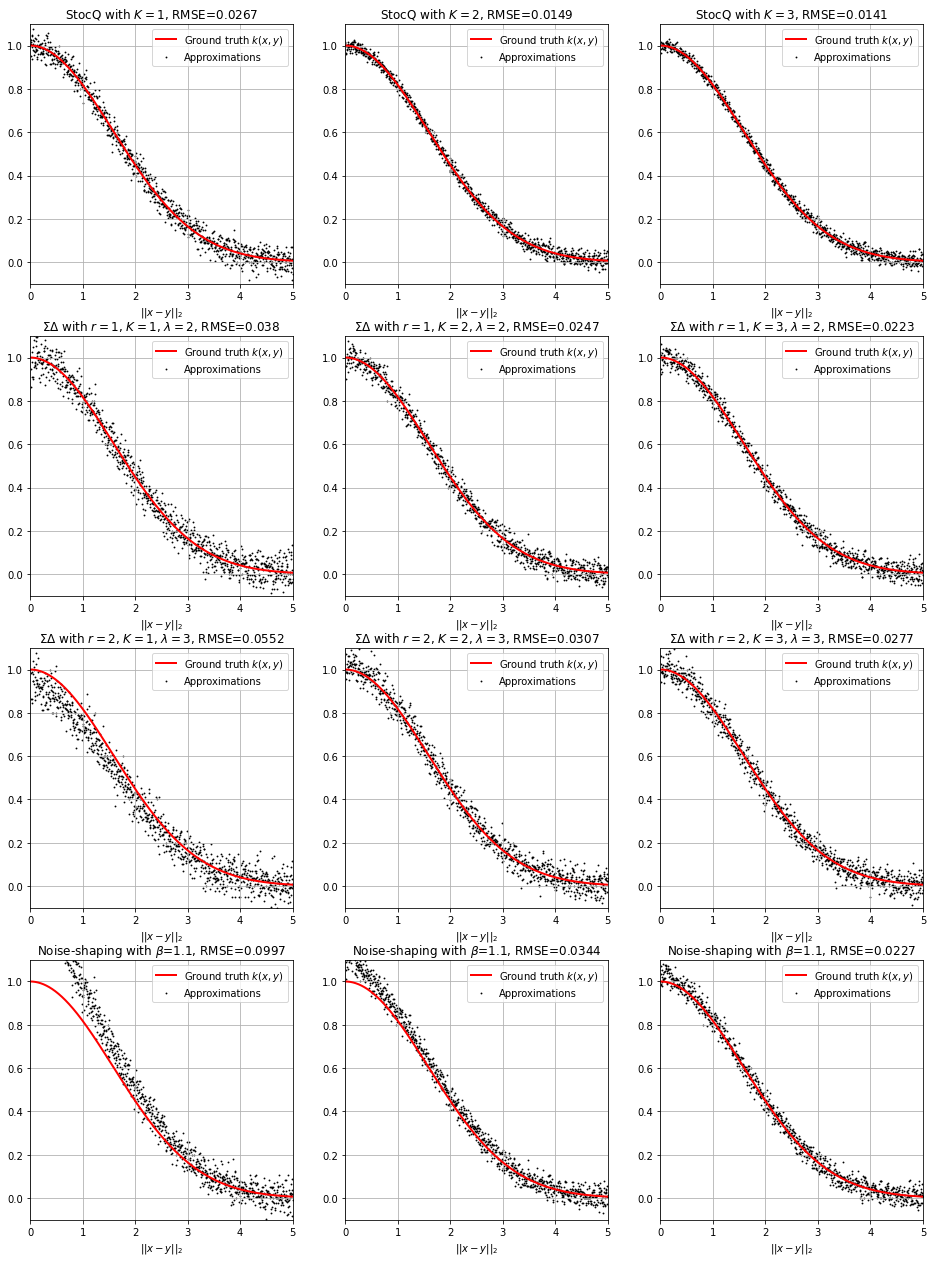

In [4]:
d = 10   # the dim of Euclidean space R^d 
m = 3000 # the dim of z(x) 
n = 1000  # n pairs of vectors (x_i, y_i) 
L = 5  # uper bound of distances
gamma = 2e-1

instance = Experiments(d, m, n)
instance.data_generator(L, gamma, 'l2')

q_type_list = ['StocQ', 'r1', 'r2', 'beta']
beta = 1.1
lambda_list = [1, 2, 3, 2]
SDQ_level_list = [1, 2, 3]
fig = plt.figure(figsize=(16,22))
xdata = np.arange(n) * L / (n-1)
for i, q_type in enumerate(q_type_list):
    for j in range(len(SDQ_level_list)):
        ax = fig.add_subplot(4,len(SDQ_level_list),i*len(SDQ_level_list)+j+1)
        instance.quantize(lambda_list[i], q_type, SDQ_level_list[j], SDQ_level_list[j], 2/SDQ_level_list[j]) 
        ax.plot(xdata, instance.dist_gt, linewidth=2, color='r', label='Ground truth $k(x,y)$')
        ax.scatter(xdata, instance.dist_approx, s=0.7, color= 'k', label=f'Approximations')
        if q_type == 'StocQ':
            ax.set_title(f'StocQ with $K={SDQ_level_list[j]}$, RMSE={np.round(instance.MAE(), 4)}')
        elif q_type == 'beta':
            ax.set_title(f'Noise-shaping with $\\beta$={beta}, RMSE={np.round(instance.MAE(), 4)}')
        else:
            ax.set_title(f'$\Sigma\Delta$ with $r={i}$, $K={SDQ_level_list[j]}$, $\lambda={lambda_list[i]}$, RMSE={np.round(instance.MAE(), 4)}')
        ax.legend()
        ax.axis([0, L, -0.1, 1.1])
        ax.grid(True)
        ax.set_xlabel('$||x-y||_2$')

#### Fix $b$ 

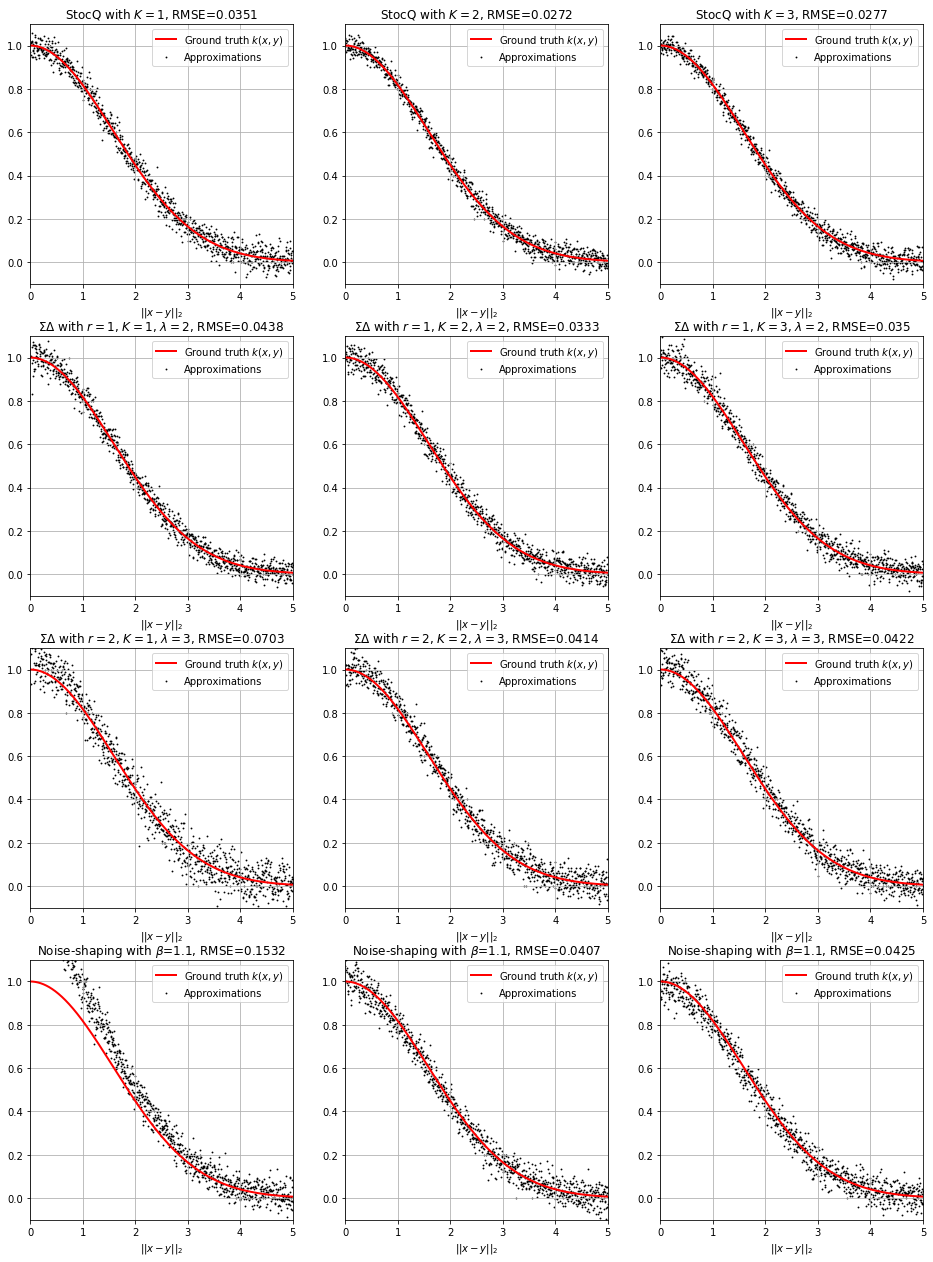

In [103]:
d = 50   # the dim of Euclidean space R^d 
n = 1000  # n pairs of vectors (x_i, y_i) 
L = 5  # uper bound of distances
gamma = 2e-1

q_type_list = ['StocQ', 'r1', 'r2', 'beta']
lambda_list = [1, 2, 3, 2]
SDQ_level_list = [1, 2, 3]
beta = 1.1
bit = 3000
fig = plt.figure(figsize=(16,22))
xdata = np.arange(n) * L / (n-1)
for i, q_type in enumerate(q_type_list):
    for j in range(len(SDQ_level_list)):
        ax = fig.add_subplot(4,len(SDQ_level_list),i*len(SDQ_level_list)+j+1)
        m = compute_m(bit, lambda_list[i], SDQ_level_list[j], i)
        instance = Experiments(d, m, n)
        instance.data_generator(L, gamma, 'l2')
        instance.quantize(lambda_list[i], q_type, SDQ_level_list[j], SDQ_level_list[j]) 
        ax.plot(xdata, instance.dist_gt, linewidth=2, color='r', label='Ground truth $k(x,y)$')
        ax.scatter(xdata, instance.dist_approx, s=0.7, color= 'k', label=f'Approximations')
        if q_type == 'StocQ':
            ax.set_title(f'StocQ with $K={SDQ_level_list[j]}$, RMSE={np.round(instance.RMSE(), 4)}')
        elif q_type == 'beta':
            ax.set_title(f'Noise-shaping with $\\beta$={beta}, RMSE={np.round(instance.RMSE(), 4)}')
        else:
            ax.set_title(f'$\Sigma\Delta$ with $r={i}$, $K={SDQ_level_list[j]}$, $\lambda={lambda_list[i]}$, RMSE={np.round(instance.RMSE(), 4)}')
        ax.legend()
        ax.axis([0, L, -0.1, 1.1])
        ax.grid(True)
        ax.set_xlabel('$||x-y||_2$')

[0.01818876 0.07784062]


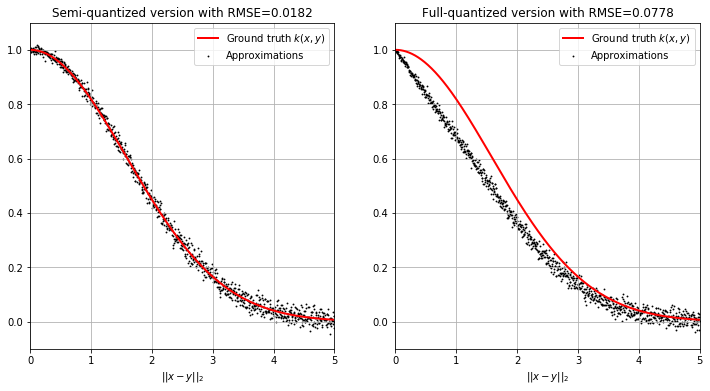

In [3]:
d = 50   # the dim of Euclidean space R^d 
m = 3000  # the dim of z(x) 
n = 1000  # n pairs of vectors (x_i, y_i) 
L = 5  # uper bound of distances
gamma = 2e-1

instance = Experiments(d, m, n)
instance.data_generator(L, gamma, 'l2')

q_type_list = ['universal', 'universal-full']
title_list = ['Semi-quantized version', 'Full-quantized version'] 
RMSE_list = np.zeros(len(q_type_list))
fig = plt.figure(figsize=(12,6))
xdata = np.arange(n) * L / (n-1)
for i in range(len(q_type_list)):
    ax = fig.add_subplot(1,2,i+1)
    instance.quantize(1, q_type_list[i], 1)   # we can change the level
    RMSE_list[i] = instance.RMSE()
    ax.plot(xdata, instance.dist_gt, linewidth=2, color='r', label='Ground truth $k(x,y)$')
    ax.scatter(xdata, instance.dist_approx, s=0.7, color= 'k', label=f'Approximations')
    ax.set_title(title_list[i]+f' with RMSE={np.round(RMSE_list[i], 4)}')
    ax.legend()
    ax.axis([0, L, -0.1, 1.1])
    ax.grid(True)
    ax.set_xlabel('$||x-y||_2$')
print(RMSE_list)
# plt.savefig('approx-universal.png')

0.04615344632273194


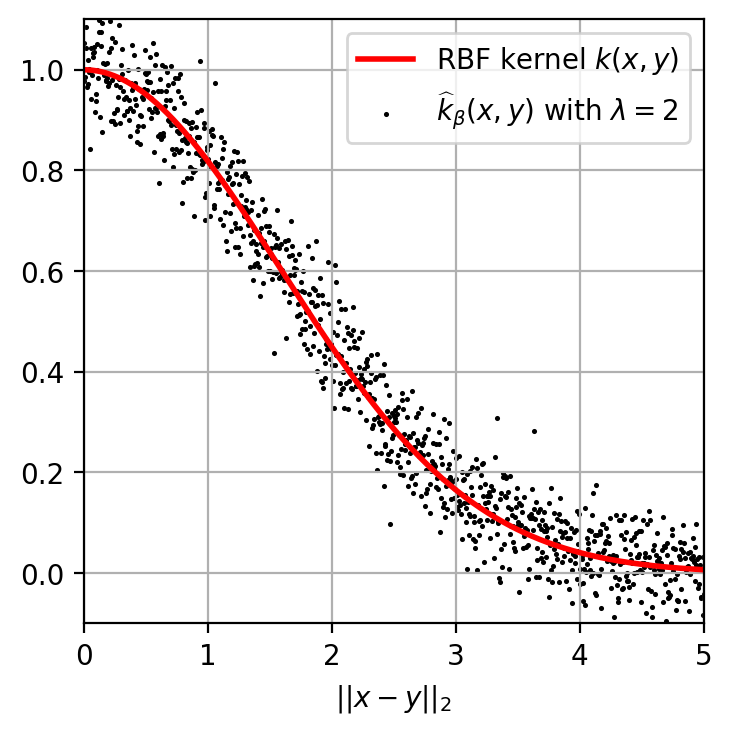

In [59]:
d = 50   # the dim of Euclidean space R^d 
m = 3000  # the dim of z(x) 
n = 1000  # n pairs of vectors (x_i, y_i) 
L = 5  # uper bound of distances
gamma = 2e-1

index = 5
level = 1
instance = Experiments(d, m, n)
instance.data_generator(L, gamma, 'l2')
beta = 1.9
lambda_list = [1, 1, 1, 5, 3, 10]

q_type_list = ['universal', 'universal-full', 'StocQ', 'r1', 'r2', 'beta']
label_list = ['$\widehat{k}_{s}(x,y)$', '$\widehat{k}_{q}(x,y)$', '$\widehat{k}_{StocQ}(x,y)$', '$\widehat{k}^{(1)}_{\Sigma\Delta}(x,y)$ with $\lambda=2$',
                  '$\widehat{k}^{(2)}_{\Sigma\Delta}(x,y)$ with $\lambda=3$', '$\widehat{k}_{\\beta}(x,y)$ with $\lambda=2$']
RMSE_list = np.zeros(len(q_type_list))
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(1,1,1)
xdata = np.arange(n) * L / (n-1)

instance.quantize(lambda_list[index], q_type_list[index], level, level)   # we can change the level
ax.plot(xdata, instance.dist_gt, linewidth=2, color='r', label='RBF kernel $k(x,y)$')
ax.scatter(xdata, instance.dist_approx, s=0.7, color= 'k', label=label_list[index])
ax.legend()
ax.axis([0, L, -0.1, 1.1])
ax.grid(True)
ax.set_xlabel('$||x-y||_2$')
print(instance.MAE())
#plt.savefig(f'approx-{q_type_list[index]}.png')

### (b) Kernel PCA

In [47]:
d = 10  # the dim of Euclidean space R^d 
m = 3000  # the dim of z(x) 
n = 500  # n pairs of vectors (x_i, y_i) 
L = 5  # uper bound of distances
gamma = 6e-1

instance = Experiments(d, m, n)
instance.data_generator(L, gamma, 'l2')

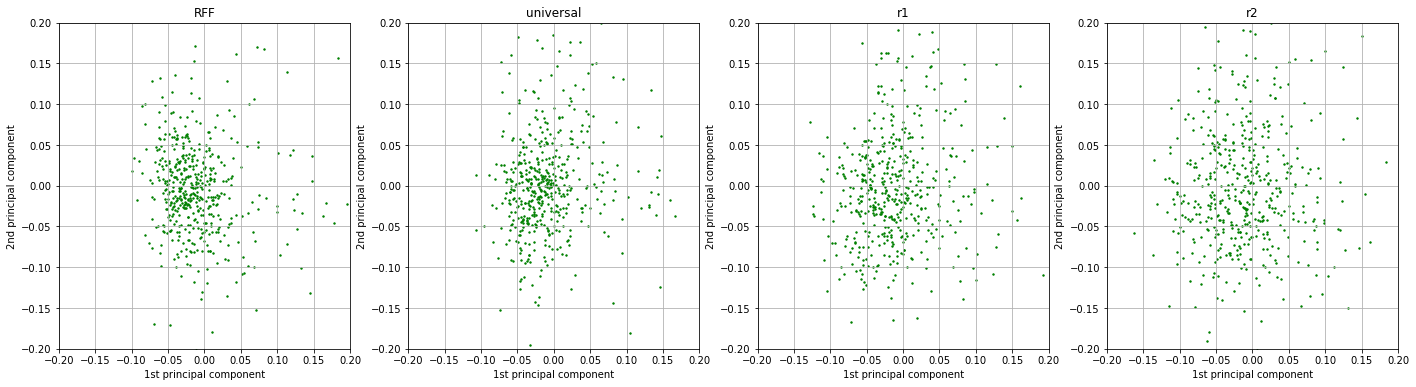

In [48]:
q_type_list = ['RFF', 'universal', 'r1', 'r2']
title_list = ['$z(x)$', '$\frac{1}{m}z_q(x)$', 'Full-quantized version'] 
lambda_list = [2, 3]
SDQ_bit_list = [5, 5]
fig = plt.figure(figsize=(24,6))
for i, q_type in enumerate(q_type_list):
    ax = fig.add_subplot(1,len(q_type_list),i+1)
    if q_type == 'r1':
        data = instance.kernel_pca(lambda_list[0], q_type, SDQ_bit_list[0])
        ax.scatter(data[:,0], data[:,1], s=2, color= 'g')
    elif q_type == 'r2':
        data = instance.kernel_pca(lambda_list[1], q_type, SDQ_bit_list[1])
        ax.scatter(data[:,0], data[:,1], s=2, color= 'g')
    else:
        data = instance.kernel_pca(1, q_type)
        ax.scatter(data[:,0], data[:,1], s=2, color= 'g')
    ax.set_title(q_type)
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.axis([-0.2, 0.2, -0.2, 0.2])
    ax.grid(True)

## (3) Semi-quantized support vector machines

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = load_digits(return_X_y=True)
X = X / 16
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=12)
d = X.shape[1]     # the dim of Euclidean space R^d 
C = 10  # the number of classes (clusters)

# clf = SVC(C=1, kernel='rbf', gamma=1.25e-1)
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

In [3]:
def decision_function(sv, nv, a, b, X, kernel_type):
    # calculate the kernels
    k = kernel(sv, X, kernel_type)

    # define the start and end index for support vectors for each class
    start = [sum(nv[:i]) for i in range(len(nv))]
    end = [start[i] + nv[i] for i in range(len(nv))]

    # calculate: sum(a_p * k(x_p, x)) between every 2 classes
    result = [sum(a[i][p] * k[p] for p in range(start[j], end[j])) +
          sum(a[j-1][p] * k[p] for p in range(start[i], end[i]))
                for i in range(len(nv)) for j in range(i+1,len(nv))]

    # add the intercept
    return [sum(x) for x in zip(result, b)]

def predict(sv, nv, a, b, C, X, kernel_type):
    decision = decision_function(sv, nv, a, b, X, kernel_type)
    votes = [(i if decision[p] > 0 else j) for p,(i,j) in enumerate((i,j) 
                                           for i in range(C)
                                           for j in range(i+1,C))]
    return max(set(votes), key=votes.count)

def kernel(sv, X, kernel_type):
    if kernel_type == 'rbf':
        return [np.exp(-gamma * np.linalg.norm(vi - X, axis=-1) ** 2) for vi in sv]
    elif kernel_type == 'RFF':
        X_RFF = np.cos(omega.T @ X.reshape((d, 1)) + xi).flatten()
        sv_RFF = np.cos(omega.T @ sv.T + xi @ np.ones((1, sv.shape[0]))).T
        return [2/m * np.dot(sv_RFF[i], X_RFF) for i in range(sv_RFF.shape[0])]
    elif kernel_type == 'universal-1':
        X_q = np.sign(np.cos(omega.T @ X.reshape((d, 1)) + xi)).flatten()
        sv_RFF = np.cos(omega.T @ sv.T + xi @ np.ones((1, sv.shape[0]))).T
        return [np.pi/(2*m) * np.dot(sv_RFF[i], X_q) for i in range(sv_RFF.shape[0])]
    elif kernel_type == 'universal-2':
        X_RFF = np.cos(omega.T @ X.reshape((d, 1)) + xi).flatten()
        sv_RFF = np.cos(omega.T @ sv.T + xi @ np.ones((1, sv.shape[0]))).T
        sv_q = np.sign(sv_RFF)
        return [np.pi/(2*m) * np.dot(sv_q[i], X_RFF) for i in range(sv_RFF.shape[0])]
    elif kernel_type == 'StocQ':
        X_q = StocQ(np.cos(omega.T @ X.reshape((d, 1)) + xi), SDQ_level_list[0]).flatten() * np.sqrt(2/m) 
        return [np.dot(sv[i], X_q) for i in range(sv.shape[0])]        
    elif kernel_type == 'r1':
        X_RFF = np.cos(omega.T @ X.reshape((d, 1)) + xi).reshape((1, m))
        X_q = SDQ(X_RFF, 1, SDQ_level_list[1]).reshape((m, 1))    
        return [float((V @ X_q).T @ clf.support_vectors_[i].reshape((p,1))) for i in range(sv.shape[0])]
    elif kernel_type == 'r2':
        X_RFF = np.cos(omega.T @ X.reshape((d, 1)) + xi).reshape((1, m))
        X_q = SDQ(X_RFF, 2, SDQ_level_list[2]).reshape((m, 1))    
        return [float((V @ X_q).T @ clf.support_vectors_[i].reshape((p,1))) for i in range(sv.shape[0])]
    elif kernel_type == 'beta':
        X_RFF = np.cos(omega.T @ X.reshape((d, 1)) + xi).reshape((1, m))
        X_q = BetaQ(X_RFF, beta, lambda_, SDQ_level_list[3]).reshape((m, 1))    
        return [float((V @ X_q).T @ clf.support_vectors_[i].reshape((p,1))) for i in range(sv.shape[0])]

m_list = np.array([15, 33, 63, 129, 255, 513]) * 16 
lambda_dict = dict(r1=2, r2=3, beta=2)
SDQ_level_list = [2, 2, 2, 2]
beta = 1.1
gamma = 1/(X.shape[1] * X.var())  # 1/X.shape[1]  1/(X.shape[1] * X.var())
print('gamma is', gamma)
M = 30 # the number of repeated experiments 
q_type_list = ['rbf', 'RFF', 'universal-1', 'universal-2', 'StocQ', 'r1', 'r2', 'beta']
test_accuracy = np.zeros((M, len(q_type_list), len(m_list)))
bit_array = np.zeros((M, 3, len(m_list)))

for t in range(M):
    print(t)
    for j, m in enumerate(m_list):
        xi = np.random.uniform(0, 2*np.pi, size=(m,1))
        omega = np.random.randn(d, m) * np.sqrt(2*gamma) 
        for i, q_type in enumerate(q_type_list):
            if q_type == 'rbf':
                if t == 0 and j == 0:
                    clf = SVC(C=1.0, kernel='rbf', gamma=gamma)
                    clf.fit(X_train, y_train)
                    sv = X_train[clf.support_]
                    nv = clf.n_support_
                    a  = clf.dual_coef_
                    b  = clf.intercept_
                    index = clf.support_
                    predictions = np.zeros(X_test.shape[0]).astype('int')
                    for k in range(X_test.shape[0]):
                        predictions[k] = predict(sv, nv, a, b, C, X_test[k], q_type)
                    test_accuracy[t, i, j] = np.sum(predictions == y_test) / X_test.shape[0]
                else:
                    test_accuracy[t, i, j] = test_accuracy[0, i, 0]
            elif q_type in ['RFF', 'universal-1', 'universal-2']:
                X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
                clf = SVC(C=1.0, kernel='linear')
                clf.fit(X_train_RFF, y_train)
                sv = X_train[clf.support_]
                nv = clf.n_support_
                a  = clf.dual_coef_
                b  = clf.intercept_
                index = clf.support_
                predictions = np.zeros(X_test.shape[0]).astype('int')
                for k in range(X_test.shape[0]):
                    predictions[k] = predict(sv, nv, a, b, C, X_test[k], q_type)
                test_accuracy[t, i, j] = np.sum(predictions == y_test) / X_test.shape[0]
            elif q_type == 'StocQ':
                X_train_q = StocQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, SDQ_level_list[0]) * np.sqrt(2/m)
                clf = SVC(C=1.0, kernel='linear')
                clf.fit(X_train_q, y_train)
                sv = X_train_q[clf.support_]
                nv = clf.n_support_
                a  = clf.dual_coef_
                b  = clf.intercept_
                index = clf.support_
                predictions = np.zeros(X_test.shape[0]).astype('int')
                for k in range(X_test.shape[0]):
                    predictions[k] = predict(sv, nv, a, b, C, X_test[k], q_type)
                test_accuracy[t, i, j] = np.sum(predictions == y_test) / X_test.shape[0]
            elif q_type in ['r1', 'r2', 'beta']:
                lambda_ = lambda_dict[q_type]
                p = int(m/lambda_)
                if q_type == 'r1':
                    v = np.ones(lambda_)  # row vector v
                    V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)  # normalized sparse V
                    X_train_q = (V @ SDQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, 1, SDQ_level_list[1]).T).T
                    bit_array[t,0,j] = p * avg_bit(X_train_q)
                elif q_type == 'r2':
                    v = np.concatenate([np.arange(1,(lambda_+1)/2+1), np.arange((lambda_-1)/2, 0, -1)])
                    V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)
                    X_train_q = (V @ SDQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, 2, SDQ_level_list[2]).T).T
                    bit_array[t,1,j] = p * avg_bit(X_train_q)
                elif q_type == 'beta':
                    v = beta ** np.arange(-1, -lambda_-1, -1)
                    V = np.sqrt(2/p) * np.kron(np.eye(p), v) / (np.linalg.norm(v) * (2*SDQ_level_list[3]-beta)/(2*SDQ_level_list[3]-1))
                    X_train_q = (V @ BetaQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, beta, lambda_, SDQ_level_list[3]).T).T
                    bit_array[t,2,j] = p * avg_bit(X_train_q)
                clf = SVC(C=1.0, kernel='linear')
                clf.fit(X_train_q, y_train)
                sv = X_train_q[clf.support_]
                nv = clf.n_support_
                a  = clf.dual_coef_
                b  = clf.intercept_
                index = clf.support_
                predictions = np.zeros(X_test.shape[0]).astype('int')
                for k in range(X_test.shape[0]):
                    predictions[k] = predict(sv, nv, a, b, C, X_test[k], q_type)
                test_accuracy[t, i, j] = np.sum(predictions == y_test) / X_test.shape[0]
# test_accuracy = test_accuracy.mean(axis=0)
# bit_array = bit_array.mean(axis=0)
np.save('test_accuracy_svm_K'+str(SDQ_level_list[0]), test_accuracy)
np.save('bit_array_svm_K'+str(SDQ_level_list[0]), bit_array)

gamma is 0.11049194980936383
0


KeyboardInterrupt: 

### $K=1$

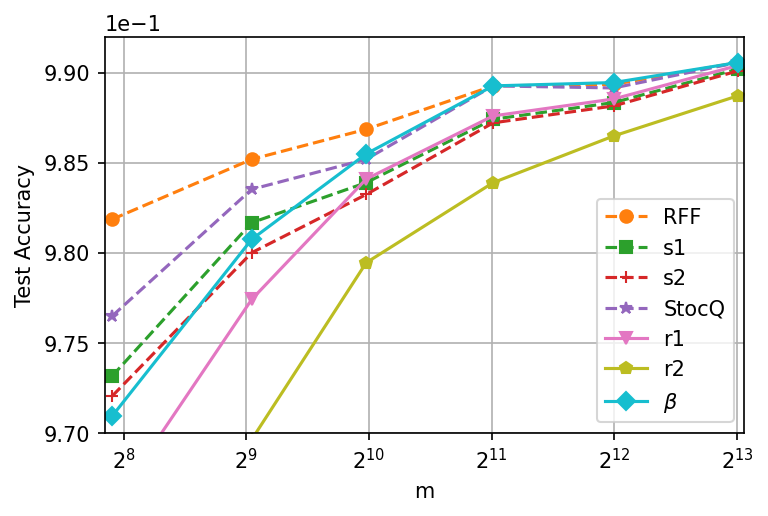

In [11]:
test_accuracy = np.load('test_accuracy_svm_b2.npy')
fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=150)
q_list = ['rbf', 'RFF', 's1', 's2', 'StocQ', 'r1', 'r2', '$\\beta$']
markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']

for i, q_type in enumerate(q_type_list):
    if q_type in ['r1', 'r2', 'beta']:
        ax.plot(m_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type == 'rbf':
        continue
    else:       
        ax.plot(m_list, test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_list[i])
ax.legend()
ax.ticklabel_format(style='sci',scilimits=(-1,-1), axis='y')
yloc = plt.MaxNLocator(5)
ax.yaxis.set_major_locator(yloc)
ax.axis([m_list[0]-10, m_list[-1]+300, 9.7e-1, 0.992]) 
ax.grid(True)
ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.set_xlabel('m')
ax.set_ylabel('Test Accuracy')
#ax.set_title('Prediction Accuracy on testing dataset') 
plt.savefig('ksvm_b2_m.png')

In [56]:
K= 4
q_type = 'r2'
[int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in np.array([15, 33, 63, 129, 255, 513, 1026]) * 16]

[384, 846, 1615, 3307, 6538, 13152, 26305]

In [55]:
test_accuracy

array([[0.99166667, 0.99166667, 0.99166667, 0.99166667, 0.99166667,
        0.99166667],
       [0.98074074, 0.98481481, 0.98722222, 0.98925926, 0.99      ,
        0.99092593],
       [0.97111111, 0.98      , 0.98555556, 0.98760741, 0.98925926,
        0.99018519],
       [0.97240741, 0.98      , 0.98555556, 0.98730741, 0.98907407,
        0.98998519],
       [0.98055556, 0.98462963, 0.98703704, 0.98895926, 0.9898    ,
        0.99092593],
       [0.97092593, 0.98240741, 0.98605556, 0.98833333, 0.98935926,
        0.99038519],
       [0.95537037, 0.97611111, 0.98240741, 0.98592593, 0.98833333,
        0.99      ],
       [0.975     , 0.98296296, 0.98722222, 0.98905926, 0.9899    ,
        0.99082593]])

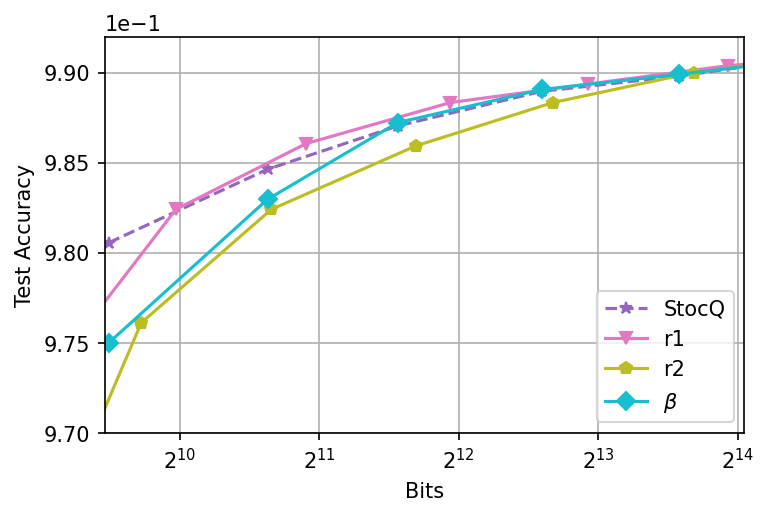

In [67]:
# Use the upper bound of bits
# test_accuracy = np.load('test_accuracy_svm.npy')
fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=150)  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
K = 4
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_dict[q_type]*(2*K-1))*m/lambda_dict[q_type]) for m in m_list]
        ax.plot(bit_list+[31250], np.concatenate((test_accuracy[i],[0.991])), linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])  
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in m_list]    
        ax.plot(bit_list+[26305], np.concatenate((test_accuracy[i],[0.991])), linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i]) 
    elif q_type == 'beta':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type in ['rbf', 'RFF', 'universal-1', 'universal-2']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list , test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend(loc='lower right')
ax.ticklabel_format(style='sci',scilimits=(-1,-1), axis='y')
yloc = plt.MaxNLocator(5) 
ax.yaxis.set_major_locator(yloc)
ax.axis([bit_list[0]-15, 2**14 +500, 9.7e-1, 0.992]) 
ax.grid(True)
ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Bits')
#ax.set_title('Prediction Accuracy on testing dataset') 
plt.savefig('ksvm_b3_bit.png')

### $K=2$

Text(0.5, 1.0, 'Prediction Accuracy on testing dataset')

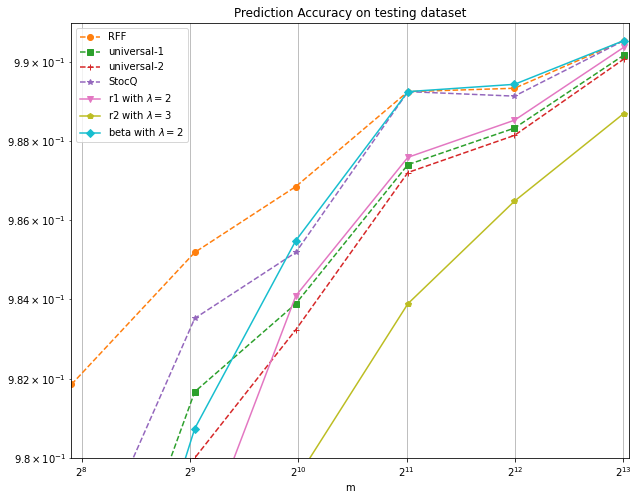

In [179]:
test_accuracy = np.load('test_accuracy_svm_b2.npy')
fig, ax = plt.subplots(figsize=(10,8))  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
for i, q_type in enumerate(q_type_list):
    if q_type in ['r1', 'r2', 'beta']:
        ax.plot(m_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'rbf':
        continue
    else:       
        ax.plot(m_list, test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.axis([m_list[0]-0.1, m_list[-1]+300, 9.8e-1, 0.991]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('m')
ax.set_title('Prediction Accuracy on testing dataset') 
#plt.savefig('test_accuracy_scale.png')

Text(0.5, 1.0, 'Prediction Accuracy on testing dataset')

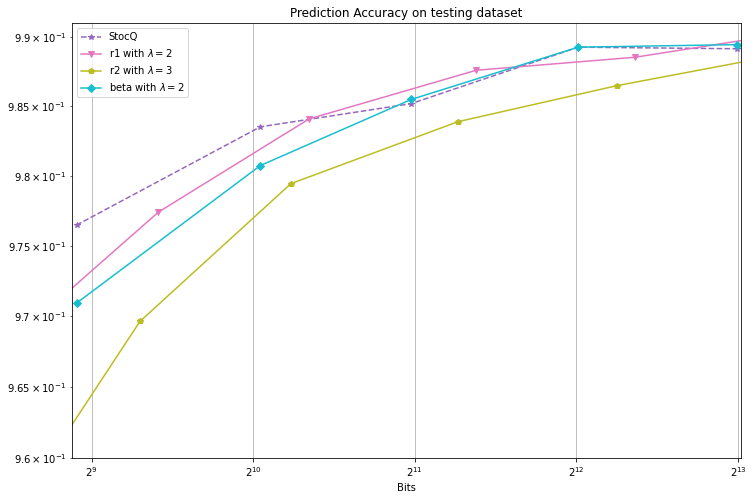

In [180]:
# Use the upper bound of bits
# test_accuracy = np.load('test_accuracy_svm.npy')
fig, ax = plt.subplots(figsize=(12,8))  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
K = 2
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_dict[q_type]*(2*K-1))*m/lambda_dict[q_type]) for m in m_list]
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in m_list]    
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'beta':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type in ['rbf', 'RFF', 'universal-1', 'universal-2']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list , test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.axis([bit_list[0]-10, m_list[-1]+100, 9.6e-1, 0.991]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('Bits')
ax.set_title('Prediction Accuracy on testing dataset') 
#plt.savefig('test_accuracy_scale.png')

### $K=4$

Text(0.5, 1.0, 'Prediction Accuracy on testing dataset')

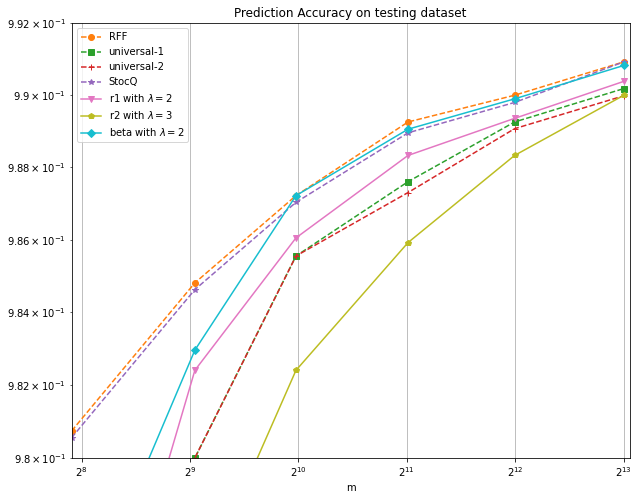

In [181]:
test_accuracy = np.load('test_accuracy_svm_b3.npy')
fig, ax = plt.subplots(figsize=(10,8))  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
for i, q_type in enumerate(q_type_list):
    if q_type in ['r1', 'r2', 'beta']:
        ax.plot(m_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'rbf':
        continue
    else:       
        ax.plot(m_list, test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.axis([m_list[0]-0.1, m_list[-1]+300, 9.8e-1, 0.992]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('m')
ax.set_title('Prediction Accuracy on testing dataset') 
#plt.savefig('test_accuracy_scale.png')

Text(0.5, 1.0, 'Prediction Accuracy on testing dataset')

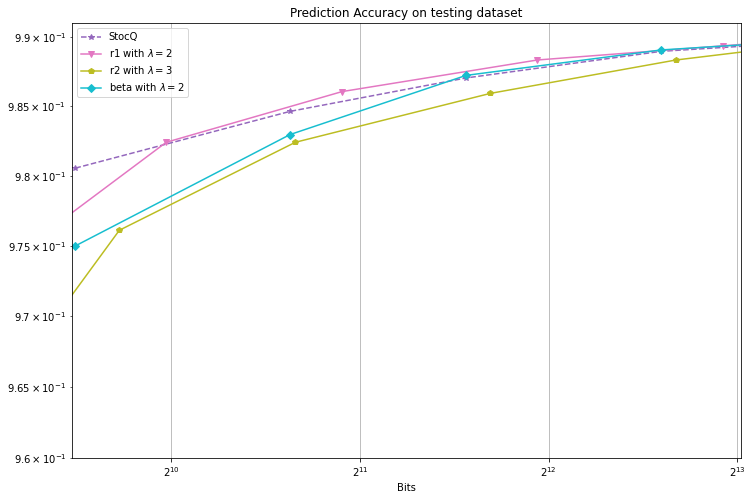

In [182]:
fig, ax = plt.subplots(figsize=(12,8))  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
K = 4
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_dict[q_type]*(2*K-1))*m/lambda_dict[q_type]) for m in m_list]
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in m_list]    
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'beta':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type in ['rbf', 'RFF', 'universal-1', 'universal-2']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list , test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.axis([bit_list[0]-10, m_list[-1]+100, 9.6e-1, 0.991]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('Bits')
ax.set_title('Prediction Accuracy on testing dataset') 
#plt.savefig('test_accuracy_scale.png')

## (4) Quantized kernel ridge regression

Reference: [Kernel-Ridge](https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-Ridge.pdf)

Let $d$ be the number of features. For each $i$, we draw $x_i$ from $U([-1,1))$ and use it to generate 
$$ y_i = \beta_1^\top x_i +\beta_2^\top \cos(x_i^2) + \beta_3^\top \cos(|x_i|) + \epsilon_i $$
where $\beta_1=\beta_2=\beta_3=[1,1,\ldots, 1]$, and $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$.

In [2]:
n_samples = 3000
n_features = 3
n_train = int(0.8 * n_samples)
sigma = 0.5 # 0.3 or 0.75
X = 0.5 * (2 * np.random.rand(n_samples, n_features) - 1) 
gamma = 3 / n_features ** 2 # 1/(X.shape[1] * X.var())  1/X.shape[1]  
print(f'gamma is {gamma}') 
beta1 = np.ones((n_features, 1)) 
beta2 = np.ones((n_features, 1))   # np.arange(1, n_features+1).reshape((n_features,1))
beta3 = np.ones((n_features, 1)) 
y = (X @ beta1 + np.cos(X ** 2) @ beta2 + np.cos(np.abs(X)) @ beta3 +  sigma * np.random.randn(n_samples, 1)).flatten() 
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]  
(np.abs(X @ beta1)).mean(), np.abs(np.cos(X ** 2) @ beta2).mean(), np.abs(np.cos(np.abs(X)) @ beta3).mean(), np.abs(0.2 * np.random.randn(n_samples, 1)).mean()

gamma is 0.3333333333333333


(0.4073975620027873,
 2.9810971474077306,
 2.8755116436131773,
 0.15949736455109864)

In [21]:
m_list = np.array([15, 30, 60, 120, 255, 510]) * 16 
print('m_list is', m_list)
lambda_dict = dict(r1=15, r2=15, beta=12)
beta = 1.9
SDQ_level_list = [1, 1, 1, 1]
M = 30 # the number of repeated experiments 
q_type_list = ['rbf', 'RFF', 'universal-1', 'universal-2', 'StocQ', 'r1', 'r2', 'beta']
test_mse = np.zeros((M, len(q_type_list), len(m_list)))
bit_array = np.zeros((M, 3, len(m_list)))
reg = 1  # regularization coefficient

for t in range(M):
    print('iteration', t)
    for j, m in enumerate(m_list):
        xi = np.random.uniform(0, 2*np.pi, size=(m,1))
        omega = np.random.randn(n_features, m) * np.sqrt(2*gamma) 
        for i, q_type in enumerate(q_type_list):
            if q_type == 'rbf':
                if t == 0 and j ==0:
                    K_train = np.zeros((X_train.shape[0], X_train.shape[0]))
                    for k in range(X_train.shape[0]):
                        for l in range(X_train.shape[0]):
                            K_train[k,l] = np.exp(-gamma * np.linalg.norm(X_train[k]-X_train[l])**2)
                    alpha = np.linalg.solve(K_train + reg * np.eye(X_train.shape[0]), y_train)
                    K_test = np.zeros((X_test.shape[0], X_train.shape[0]))
                    for k in range(X_test.shape[0]):
                        for l in range(X_train.shape[0]):
                            K_test[k,l] = np.exp(-gamma * np.linalg.norm(X_test[k]-X_train[l])**2)
                    y_predict = K_test @ alpha
                    test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2)
                    print(f'Lower bound of MSE is around {test_mse[t, i, j]}.')
                else:
                    test_mse[t, i, j] = test_mse[0, i, 0]         
            elif q_type == 'RFF':
                X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
                alpha = np.linalg.solve(X_train_RFF @ X_train_RFF.T + reg * np.eye(X_train_RFF.shape[0]), y_train)
                X_test_RFF = np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T * np.sqrt(2/m)
                y_predict = (X_test_RFF @ X_train_RFF.T) @ alpha
                test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2)
            elif q_type == 'universal-1':
                X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
                alpha = np.linalg.solve(X_train_RFF @ X_train_RFF.T + reg * np.eye(X_train_RFF.shape[0]), y_train)
                X_test_q = np.sign(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0])))).T * np.pi/np.sqrt(8*m)
                y_predict = (X_test_q @ X_train_RFF.T) @ alpha
                test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2) 
            elif q_type == 'universal-2':
                X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
                alpha = np.linalg.solve(X_train_RFF @ X_train_RFF.T + reg * np.eye(X_train_RFF.shape[0]), y_train)
                X_test_RFF = np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T * np.pi/(2*m)
                X_train_q = np.sign(X_train_RFF) 
                y_predict = (X_test_RFF @ X_train_q.T) @ alpha
                test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2) 
            elif q_type == 'StocQ':
                X_train_q = StocQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))), SDQ_level_list[0]).T * np.sqrt(2/m)
                alpha = np.linalg.solve(X_train_q @ X_train_q.T + reg * np.eye(X_train_q.shape[0]), y_train)
                X_test_q = StocQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))), SDQ_level_list[0]).T * np.sqrt(2/m)
                y_predict = (X_test_q @ X_train_q.T) @ alpha
                test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2)  
            elif q_type in ['r1', 'r2', 'beta']:
                lambda_ = lambda_dict[q_type]
                p = int(m/lambda_)
                if q_type == 'r1':
                    v = np.ones(lambda_)  # row vector v
                    V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)  # normalized sparse V
                    X_train_q = (V @ SDQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, 1, SDQ_level_list[1]).T).T
                    alpha = np.linalg.solve(X_train_q @ X_train_q.T + reg * np.eye(X_train_q.shape[0]), y_train)
                    bit_array[t,0,j] = p * avg_bit(X_train_q)
                elif q_type == 'r2':
                    v = np.concatenate([np.arange(1,(lambda_+1)/2+1), np.arange((lambda_-1)/2, 0, -1)])
                    V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)
                    X_train_q = (V @ SDQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, 2, SDQ_level_list[2]).T).T
                    alpha = np.linalg.solve(X_train_q @ X_train_q.T + reg * np.eye(X_train_q.shape[0]), y_train)
                    bit_array[t,1,j] = p * avg_bit(X_train_q) 
                elif q_type == 'beta':
                    v = beta ** np.arange(-1, -lambda_-1, -1)
                    V = np.sqrt(2/p) * np.kron(np.eye(p), v) / (np.linalg.norm(v) * (2*SDQ_level_list[3]-beta)/(2*SDQ_level_list[3]-1)) 
                    X_train_q = (V @ BetaQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, beta, lambda_, SDQ_level_list[3]).T).T
                    alpha = np.linalg.solve(X_train_q @ X_train_q.T + reg * np.eye(X_train_q.shape[0]), y_train)
                    bit_array[t,2,j] = p * avg_bit(X_train_q) 
                if q_type == 'r1':
                    X_test_q = (V @ SDQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T, 1, SDQ_level_list[1]).T).T
                elif q_type == 'r2':
                    X_test_q = (V @ SDQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T, 2, SDQ_level_list[2]).T).T
                elif q_type == 'beta':
                    X_test_q = (V @ BetaQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T, beta, lambda_, SDQ_level_list[3]).T).T
                y_predict = (X_test_q @ X_train_q.T) @ alpha
                test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2)  
test_mse = test_mse.mean(axis=0)
bit_array = bit_array.mean(axis=0)
# np.save('test_mse_regression_K'+str(SDQ_level_list[0]), test_mse)
# np.save('bit_array_regressio_K'+str(SDQ_level_list[0]), bit_array)

m_list is [ 240  480  960 1920 4080 8160]
iteration 0


KeyboardInterrupt: 

### $K=1$

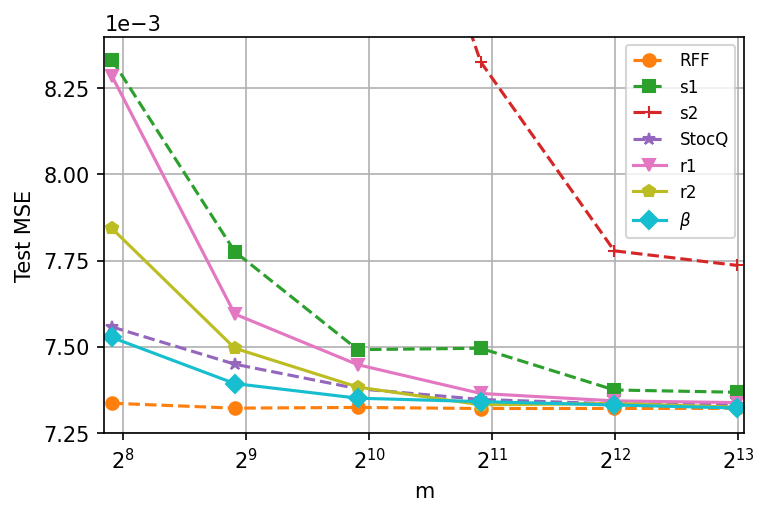

In [51]:
test_mse = np.load('test_mse_regression_b3.npy')
fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=150)  # plot the curve of accuracy
lambda_dict = dict(r1=15, r2=15, beta=12)

m_list = np.array([15, 30, 60, 120, 255, 510]) * 16 
q_type_list = ['rbf', 'RFF', 's1', 's2', 'StocQ', 'r1', 'r2', '$\\beta$']
markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
for i, q_type in enumerate(q_type_list):
    if q_type == 'rbf':
        continue
    if q_type in ['r1', 'r2', '$\\beta$']:
        ax.plot(m_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]) # +f' with $\lambda={lambda_dict[q_type]}$'
    else:       
        ax.plot(m_list, test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])


ax.legend(fontsize=8, loc='upper right', ) #bbox_to_anchor=(0.05, 1)
ax.ticklabel_format(style='sci',scilimits=(-3,-3), axis='y')
yloc = plt.MaxNLocator(5)
ax.yaxis.set_major_locator(yloc)
ax.axis([m_list[0]-10, m_list[-1]+300, 7.25e-3, 8.4e-3]) 
ax.grid(True)
ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.set_xlabel('m')
ax.set_ylabel('Test MSE')
#ax.set_title(f'MSE on testing dataset with $\gamma={np.round(gamma,2)}$ and $\sigma={sigma}$') 
# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

plt.savefig('krr_b3_m.png')

[107, 214, 429, 859, 1826, 3652]
[140, 281, 563, 1127, 2395, 4791]


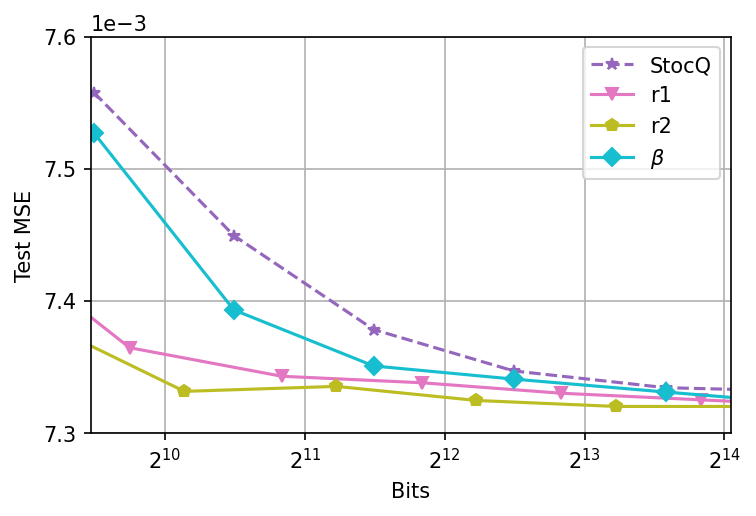

In [67]:
# Use the upper bound of bits
# test_mse = np.load('test_mse_regression.npy')
# bit_array = np.load('bit_array_regression.npy')

# plot the curve of accuracy
fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=150)  
markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
K = 4
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_dict[q_type]*(2*K-1))*m/lambda_dict[q_type]) for m in m_list]
        ax.plot(bit_list+[7305, 14610, 29220], np.concatenate((test_mse[i],[0.00733, 0.007325, 0.00732])), linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i])
        print(bit_list)
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in m_list]    
        ax.plot(bit_list+[9582, 19164], np.concatenate((test_mse[i],[0.00732, 0.00732])), linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i])
        print(bit_list)
    elif q_type == '$\\beta$':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i])
    elif q_type in ['rbf', 'RFF','s1','s2']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list , test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.ticklabel_format(style='sci',scilimits=(-3,-3), axis='y')
yloc = plt.MaxNLocator(3)
ax.yaxis.set_major_locator(yloc)
ax.axis([bit_list[0]-10, 2**14+500, 7.3e-3, 7.6e-3]) 
ax.grid(True)
ax.set_xscale('log', base=2)
#ax.set_yscale('log', base=10)
ax.set_xlabel('Bits')
ax.set_ylabel('Test MSE')
#ax.set_title(f'MSE on testing dataset with $\gamma={np.around(gamma,2)}$ and $\sigma={sigma}$') 
plt.savefig('krr_b3_bit.png')

### $K=2$

Text(0.5, 0, 'm')

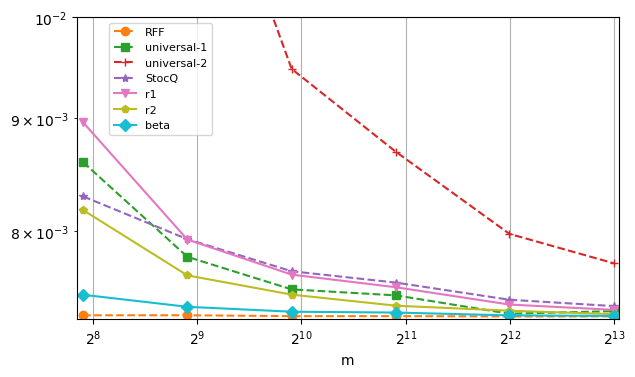

In [28]:
test_mse = np.load('test_mse_regression_b2.npy')
fig, ax = plt.subplots(figsize=(7,4), dpi=100)  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
for i, q_type in enumerate(q_type_list):
    if q_type == 'rbf':
        continue
    if q_type in ['r1', 'r2', 'beta']:
        ax.plot(m_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]) # +f' with $\lambda={lambda_dict[q_type]}$'
    else:       
        ax.plot(m_list, test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0.05, 1))
ax.axis([m_list[0]-10, m_list[-1]+300, 7.3e-3, 10e-3])  
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('m')
#ax.set_title(f'MSE on testing dataset with $\gamma={np.round(gamma,2)}$ and $\sigma={sigma}$') 
# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

#plt.savefig('test_accuracy_scale.png')

Text(0.5, 1.0, 'MSE on testing dataset with $\\gamma=0.33$ and $\\sigma=0.5$')

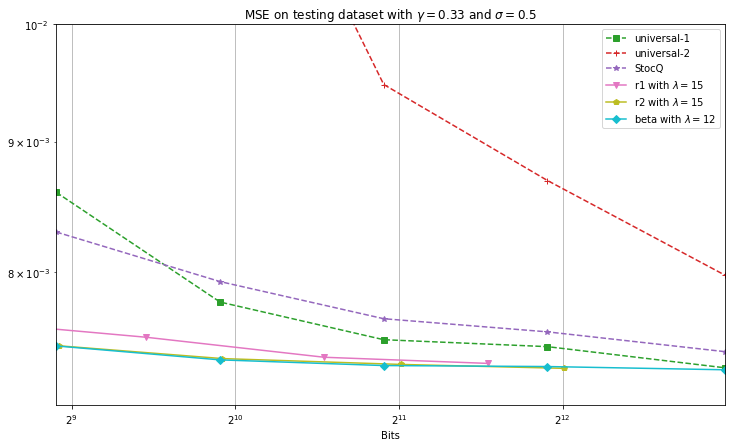

In [29]:
# Use the upper bound of bits
# test_mse = np.load('test_mse_regression.npy')
# bit_array = np.load('bit_array_regression.npy')

fig, ax = plt.subplots(figsize=(12,7))  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
K = 2
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_dict[q_type]*(2*K-1))*m/lambda_dict[q_type]) for m in m_list]
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in m_list]    
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'beta':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type in ['rbf', 'RFF']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list , test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.axis([bit_list[0]-1, m_list[-1], 7.1e-3, 10e-3]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('Bits')
ax.set_title(f'MSE on testing dataset with $\gamma={np.around(gamma,2)}$ and $\sigma={sigma}$') 
#plt.savefig('test_accuracy_scale.png')

### $K=4$

Text(0.5, 0, 'm')

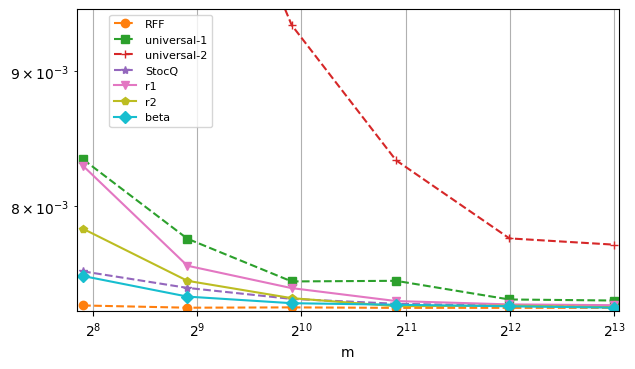

In [24]:
test_mse = np.load('test_mse_regression_b3.npy')
fig, ax = plt.subplots(figsize=(7,4), dpi=100)  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
for i, q_type in enumerate(q_type_list):
    if q_type == 'rbf':
        continue
    if q_type in ['r1', 'r2', 'beta']:
        ax.plot(m_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]) # +f' with $\lambda={lambda_dict[q_type]}$'
    else:       
        ax.plot(m_list, test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0.05, 1))
ax.axis([m_list[0]-10, m_list[-1]+300, 7.3e-3, 9.5e-3]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('m')
#ax.set_title(f'MSE on testing dataset with $\gamma={np.round(gamma,2)}$ and $\sigma={sigma}$') 
# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

#plt.savefig('test_accuracy_scale.png')

Text(0.5, 1.0, 'MSE on testing dataset with $\\gamma=0.33$ and $\\sigma=0.5$')

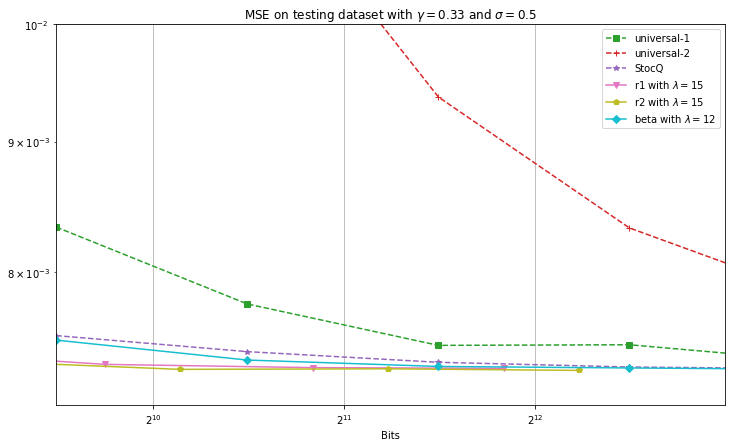

In [25]:
# Use the upper bound of bits
# test_mse = np.load('test_mse_regression.npy')
# bit_array = np.load('bit_array_regression.npy')

fig, ax = plt.subplots(figsize=(12,7))  # plot the curve of accuracy

markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
K = 4
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_dict[q_type]*(2*K-1))*m/lambda_dict[q_type]) for m in m_list]
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_dict[q_type]+1)+np.log2(2*K-1)-2)*m/lambda_dict[q_type]) for m in m_list]    
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type == 'beta':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
    elif q_type in ['rbf', 'RFF']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list , test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
ax.legend()
ax.axis([bit_list[0]-1, m_list[-1], 7.1e-3, 10e-3]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
ax.set_xlabel('Bits')
ax.set_title(f'MSE on testing dataset with $\gamma={np.around(gamma,2)}$ and $\sigma={sigma}$') 
#plt.savefig('test_accuracy_scale.png')

## (4) Maximum mean discrepancy (MMD)

In [2]:
import torch

def kernel_rbf(X, Y):
    n1, n2 = X.shape[0], Y.shape[0]
    X_core = (torch.from_numpy(X).view(n1, 1, d).expand(n1, n2, d).reshape(-1, d)).numpy()
    Y_core = (torch.from_numpy(Y).view(1, n2, d).expand(n1, n2, d).reshape(-1, d)).numpy()
    return np.exp(-gamma * ((X_core - Y_core) ** 2).sum(1)).mean()

def kernel_RFF(X, Y, omega, xi):
    n1, n2 = X.shape[0], Y.shape[0]
#     xi = np.random.uniform(0, 2*np.pi, size=(m,1))
#     omega = np.random.randn(d, m) * np.sqrt(2*gamma)
    X_RFF = torch.from_numpy(np.cos(omega.T @ X.T + xi @ np.ones((1, X.shape[0]))).T)
    Y_RFF = torch.from_numpy(np.cos(omega.T @ Y.T + xi @ np.ones((1, Y.shape[0]))).T)
    X_core = (X_RFF.view(n1, 1, m).expand(n1, n2, m).reshape(-1, m)).numpy()
    Y_core = (Y_RFF.view(1, n2, m).expand(n1, n2, m).reshape(-1, m)).numpy()   
    return (2/m) * (X_core * Y_core).sum(1).mean()
    

def kernel_semi_universal(X, Y, omega, xi):
    n1, n2 = X.shape[0], Y.shape[0]
    X_RFF = torch.from_numpy(np.cos(omega.T @ X.T + xi @ np.ones((1, X.shape[0]))).T)
    Y_q = torch.from_numpy(np.sign(np.cos(omega.T @ Y.T + xi @ np.ones((1, Y.shape[0]))).T))
    X_core = (X_RFF.view(n1, 1, m).expand(n1, n2, m).reshape(-1, m)).numpy()
    Y_core = (Y_q.view(1, n2, m).expand(n1, n2, m).reshape(-1, m)).numpy()     
    return np.pi/(2*m) * (X_core * Y_core).sum(1).mean()

def kernel_StocQ(X, Y, omega, xi):
    n1, n2 = X.shape[0], Y.shape[0]
    X_q = torch.from_numpy(StocQ(np.cos(omega.T @ X.T + xi @ np.ones((1, X.shape[0]))).T, level))
    Y_q = torch.from_numpy(StocQ(np.cos(omega.T @ Y.T + xi @ np.ones((1, Y.shape[0]))).T, level))
    X_core = (X_q.view(n1, 1, m).expand(n1, n2, m).reshape(-1, m)).numpy()
    Y_core = (Y_q.view(1, n2, m).expand(n1, n2, m).reshape(-1, m)).numpy()     
    return 2/m * (X_core * Y_core).sum(1).mean()

def kernel_r1(X, Y, omega, xi):
    n1, n2 = X.shape[0], Y.shape[0]
    v = np.ones(lambda_)  # row vector v
    p = int(m/lambda_)
    V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)  # normalized sparse V
    X_RFF = np.cos(omega.T @ X.T + xi @ np.ones((1, X.shape[0]))).T
    Y_RFF = np.cos(omega.T @ Y.T + xi @ np.ones((1, Y.shape[0]))).T
    X_q = torch.from_numpy(SDQ(X_RFF, 1, level))   # change the level if necessary 
    Y_q = torch.from_numpy(SDQ(Y_RFF, 1, level))
    X_core = V @ (X_q.view(n1, 1, m).expand(n1, n2, m).reshape(-1, m).t()).numpy()
    Y_core = V @ (Y_q.view(1, n2, m).expand(n1, n2, m).reshape(-1, m).t()).numpy()
    return (X_core * Y_core).sum(0).mean()

def kernel_r2(X, Y, omega, xi):
    n1, n2 = X.shape[0], Y.shape[0]
    v = np.concatenate([np.arange(1,(lambda_+1)/2+1), np.arange((lambda_-1)/2, 0, -1)])
    p = int(m/lambda_)
    V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)    # normalized sparse V
    X_RFF = np.cos(omega.T @ X.T + xi @ np.ones((1, X.shape[0]))).T
    Y_RFF = np.cos(omega.T @ Y.T + xi @ np.ones((1, Y.shape[0]))).T
    X_q = torch.from_numpy(SDQ(X_RFF, 2, level))
    Y_q = torch.from_numpy(SDQ(Y_RFF, 2, level))
    X_core = V @ (X_q.view(n1, 1, m).expand(n1, n2, m).reshape(-1, m).t()).numpy()
    Y_core = V @ (Y_q.view(1, n2, m).expand(n1, n2, m).reshape(-1, m).t()).numpy()
    return (X_core * Y_core).sum(0).mean()

def kernel_beta(X, Y, omega, xi):
    n1, n2 = X.shape[0], Y.shape[0]
    p = int(m/lambda_)
    v = beta ** np.arange(-1, -lambda_-1, -1)
    V = np.sqrt(2/p) * np.kron(np.eye(p), v) / (np.linalg.norm(v) * (2*level-beta)/(2*level-1))  # normalized sparse V
    X_RFF = np.cos(omega.T @ X.T + xi @ np.ones((1, X.shape[0]))).T
    Y_RFF = np.cos(omega.T @ Y.T + xi @ np.ones((1, Y.shape[0]))).T
    X_q = torch.from_numpy(BetaQ(X_RFF, beta, lambda_, level))
    Y_q = torch.from_numpy(BetaQ(Y_RFF, beta, lambda_, level))
    X_core = V @ (X_q.view(n1, 1, m).expand(n1, n2, m).reshape(-1, m).t()).numpy()
    Y_core = V @ (Y_q.view(1, n2, m).expand(n1, n2, m).reshape(-1, m).t()).numpy()
    return (X_core * Y_core).sum(0).mean()
    
def MMD(X, Y, kernel_type):
    xi = np.random.uniform(0, 2*np.pi, size=(m,1))
    omega = np.random.randn(d, m) * np.sqrt(2*gamma)
    if kernel_type == 'rbf':
        mmd = kernel_rbf(X, X) + kernel_rbf(Y, Y) - 2 * kernel_rbf(X, Y)
    elif kernel_type == 'RFF':
        mmd = kernel_RFF(X, X, omega, xi) + kernel_RFF(Y, Y, omega, xi) - 2 * kernel_RFF(X, Y, omega, xi)
    elif kernel_type == 'semi-universal':
        mmd = kernel_semi_universal(X, X, omega, xi) + kernel_semi_universal(Y, Y, omega, xi) - 2 * kernel_semi_universal(X, Y, omega, xi)
    elif kernel_type == 'StocQ':
        mmd = kernel_StocQ(X, X, omega, xi) + kernel_StocQ(Y, Y, omega, xi) - 2 * kernel_StocQ(X, Y, omega, xi)
    elif kernel_type == 'r1':
        mmd = kernel_r1(X, X, omega, xi) + kernel_r1(Y, Y, omega, xi) - 2 * kernel_r1(X, Y, omega, xi)
    elif kernel_type == 'r2':
        mmd = kernel_r2(X, X, omega, xi) + kernel_r2(Y, Y, omega, xi) - 2 * kernel_r2(X, Y, omega, xi)
    elif kernel_type == 'beta':
        mmd = kernel_beta(X, X, omega, xi) + kernel_beta(Y, Y, omega, xi) - 2 * kernel_beta(X, Y, omega, xi)
    return mmd

def MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, kernel_type, null_hypo):
    mmd_array = np.zeros(num_rounds)
    for i in range(num_rounds):
        tx = np.random.uniform(0, 0.25, n1)  # draw points from X and Y independently 
        x = np.vstack((np.cos(2*np.pi*tx), np.sin(2*np.pi*tx))).T
        ty = np.random.uniform(0, 0.25, n2)
        if null_hypo:
            y = np.vstack((np.cos(2*np.pi*ty), np.sin(2*np.pi*ty))).T
        else:
            y = np.vstack((np.cos(2*np.pi*ty)+radius*np.cos(freq*ty + phi1), np.sin(2*np.pi*ty)+radius*np.sin(freq*ty + phi2))).T
        mmd_array[i] = MMD(x, y, kernel_type)
    return mmd_array

0.03165170829945399 0.0847872215725839


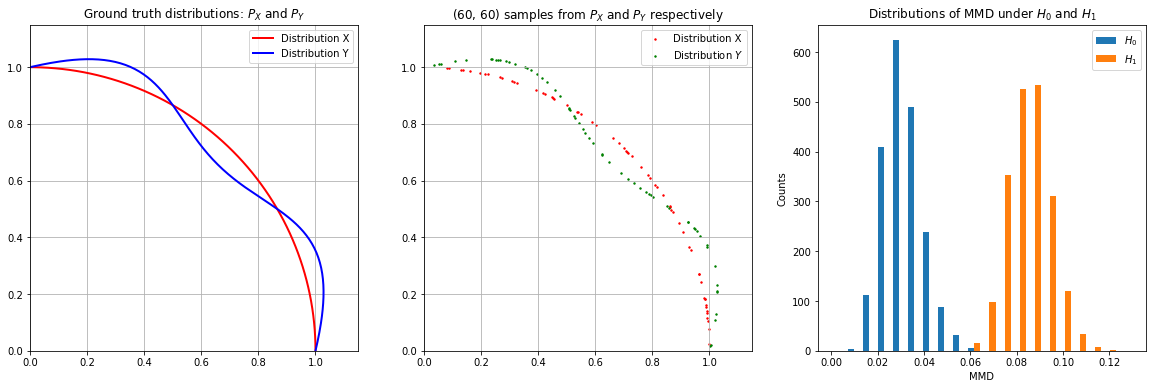

In [3]:
from matplotlib.gridspec import GridSpec

d = 2
freq = np.pi * 12
phi1 = -np.pi/2
phi2 = 0
radius = 5e-2
n1, n2 = (60, 60)
gamma = 500
num_rounds = 2000  # compute MMD independently 

fig = plt.figure(figsize=(20,6))  # plot distributions
gs = GridSpec(1,3)
ax1 = fig.add_subplot(gs[0,0])
t = np.arange(0, 0.25+1e-3, 1e-3)
x = np.vstack((np.cos(2*np.pi*t), np.sin(2*np.pi*t))).T
y = np.vstack((np.cos(2*np.pi*t)+radius*np.cos(freq*t+phi1), np.sin(2*np.pi*t)+radius*np.sin(freq*t+phi2))).T
ax1.plot(x[:,0], x[:,1], linewidth=2, color='r', label='Distribution X')
ax1.plot(y[:,0], y[:,1], linewidth=2, color='b', label='Distribution Y')
ax1.set_title('Ground truth distributions: $P_X$ and $P_Y$')
ax1.legend()
ax1.axis([0, 1.15, 0, 1.15])
ax1.grid(True)

ax2 = fig.add_subplot(gs[0, 1])    # plot dataset
tx = np.random.uniform(0, 0.25, n1)  # draw points from X and Y independently 
x = np.vstack((np.cos(2*np.pi*tx), np.sin(2*np.pi*tx))).T
ty = np.random.uniform(0, 0.25, n2)
y = np.vstack((np.cos(2*np.pi*ty)+radius*np.cos(freq*ty + phi1), np.sin(2*np.pi*ty)+radius*np.sin(freq*ty + phi2))).T
ax2.scatter(x[:,0], x[:,1], s=2, color='r', label='Distribution X')
ax2.scatter(y[:,0], y[:,1], s=2, color='g', label='Distribution $Y$')
ax2.set_title(f'({n1}, {n2}) samples from $P_X$ and $P_Y$ respectively')
ax2.legend()
ax2.axis([0, 1.15, 0, 1.15])
ax2.grid(True)

ax3 = fig.add_subplot(gs[0,2])
m = 100
mmd_null = MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, 'rbf', True)
mmd_alter = MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, 'rbf', False)
print(mmd_null.mean(), mmd_alter.mean())
ax3.hist([mmd_null, mmd_alter], bins='auto', range=[0, 1.3e-1], density=False, label=['$H_0$', '$H_1$'])  # density=False would make counts
ax3.set_title('Distributions of MMD under $H_0$ and $H_1$')
ax3.set_xlabel('MMD')
ax3.set_ylabel('Counts')
ax3.legend() 

### Single Plot

In [20]:
from matplotlib.gridspec import GridSpec

d = 2
freq = np.pi * 12
phi1 = -np.pi/2
phi2 = 0
radius = 5e-2
n1, n2 = (60, 60)
gamma = 500
num_rounds = 2000  # compute MMD independently 

t = np.arange(0, 0.25+1e-3, 1e-3)
x = np.vstack((np.cos(2*np.pi*t), np.sin(2*np.pi*t))).T
y = np.vstack((np.cos(2*np.pi*t)+radius*np.cos(freq*t+phi1), np.sin(2*np.pi*t)+radius*np.sin(freq*t+phi2))).T

In [25]:
[x[125,0], y[125,0]], [x[125,1], y[125,1]]

([0.7071067811865476, 0.6571067811865475],
 [0.7071067811865475, 0.6571067811865474])

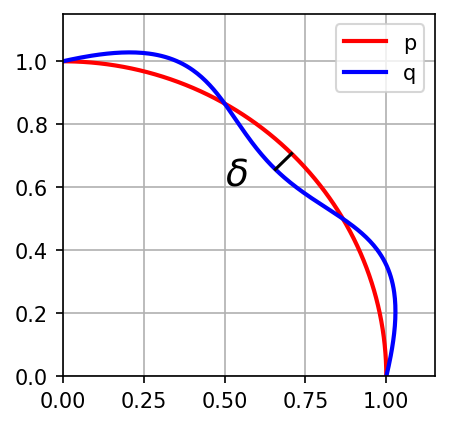

In [38]:
fig, ax = plt.subplots(figsize=(3.2,3.2), dpi=150)  # plot distributions
ax.plot(x[:,0], x[:,1], linewidth=2, color='r', label='p')
ax.plot(y[:,0], y[:,1], linewidth=2, color='b', label='q')
ax.plot([x[125,0], y[125,0]], [x[125,1], y[125,1]], color='k')
plt.text(0.5, 0.61, '$\delta$', fontsize=18)
#ax1.set_title('Ground truth distributions: $P_X$ and $P_Y$')
ax.legend()
ax.axis([0, 1.15, 0, 1.15])
ax.grid(True)
plt.savefig('MMD_xy.png')

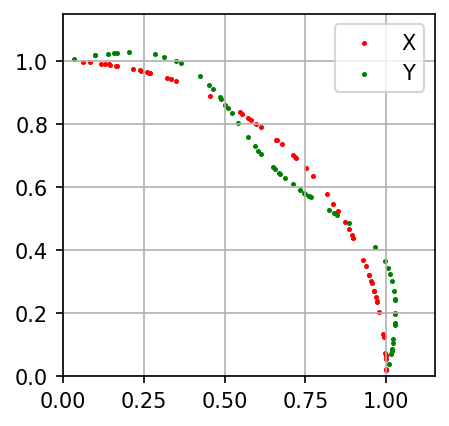

In [36]:
fig, ax = plt.subplots(figsize=(3.2,3.2), dpi=150)      # plot dataset
tx = np.random.uniform(0, 0.25, n1)  # draw points from X and Y independently 
x = np.vstack((np.cos(2*np.pi*tx), np.sin(2*np.pi*tx))).T
ty = np.random.uniform(0, 0.25, n2)
y = np.vstack((np.cos(2*np.pi*ty)+radius*np.cos(freq*ty + phi1), np.sin(2*np.pi*ty)+radius*np.sin(freq*ty + phi2))).T
ax.scatter(x[:,0], x[:,1], s=2, color='r', label='X')
ax.scatter(y[:,0], y[:,1], s=2, color='g', label='Y')
#ax.set_title(f'({n1}, {n2}) samples from $P_X$ and $P_Y$ respectively')
ax.legend()
ax.axis([0, 1.15, 0, 1.15])
ax.grid(True)
plt.savefig('MMD_xy_sample.png')

0.031201483443688758 0.08487490498396187


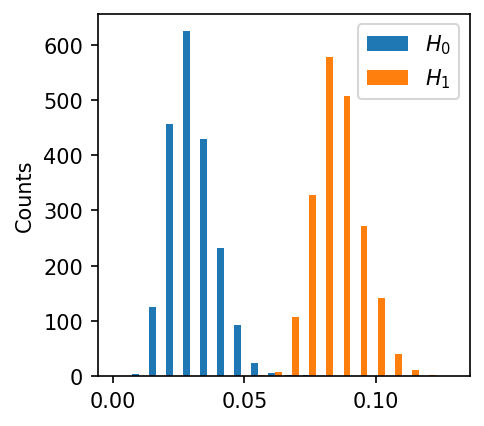

In [41]:
fig, ax = plt.subplots(figsize=(3.2,3.2), dpi=150)      
m = 100
mmd_null = MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, 'rbf', True)
mmd_alter = MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, 'rbf', False)
print(mmd_null.mean(), mmd_alter.mean())
ax.hist([mmd_null, mmd_alter], bins='auto', range=[0, 1.3e-1], density=False, label=['$H_0$', '$H_1$'])  # density=False would make counts
#ax.set_title('Distributions of MMD under $H_0$ and $H_1$')
#ax.set_xlabel('MMD')
ax.set_ylabel('Counts')
ax.legend(loc='upper right') #, bbox_to_anchor=(0.05, 1))
plt.savefig('MMD_xy_mmd.png')

### (a) Empirical Distributions

In [4]:
m_list = np.array([15, 33, 63, 129, 255]) * 4
q_type_list = ['RFF', 'semi-universal', 'StocQ', 'r1', 'r2', 'beta']
beta = 1.5
lambda_list = [4, 5, 4] 
level = 3
mmd_values_null = np.zeros((len(q_type_list), len(m_list), num_rounds))
mmd_values_alter = np.zeros((len(q_type_list), len(m_list), num_rounds))

for j, m in enumerate(m_list):
    for i, q_type in enumerate(q_type_list):
        print(j, i)
        if q_type == 'r1':
            lambda_ = lambda_list[0]
        elif q_type == 'r2':
            lambda_ = lambda_list[1]
        elif q_type == 'beta':
            lambda_ = lambda_list[2]
        mmd_values_null[i, j, :] = MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, q_type, True)
        mmd_values_alter[i, j, :] = MMD_dist(n1, n2, radius, freq, phi1, phi2, num_rounds, q_type, False)
np.save(f'n{n1}_gamma{gamma}_K{level}_null', mmd_values_null)
np.save(f'n{n1}_gamma{gamma}_K{level}_alter', mmd_values_alter)

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5


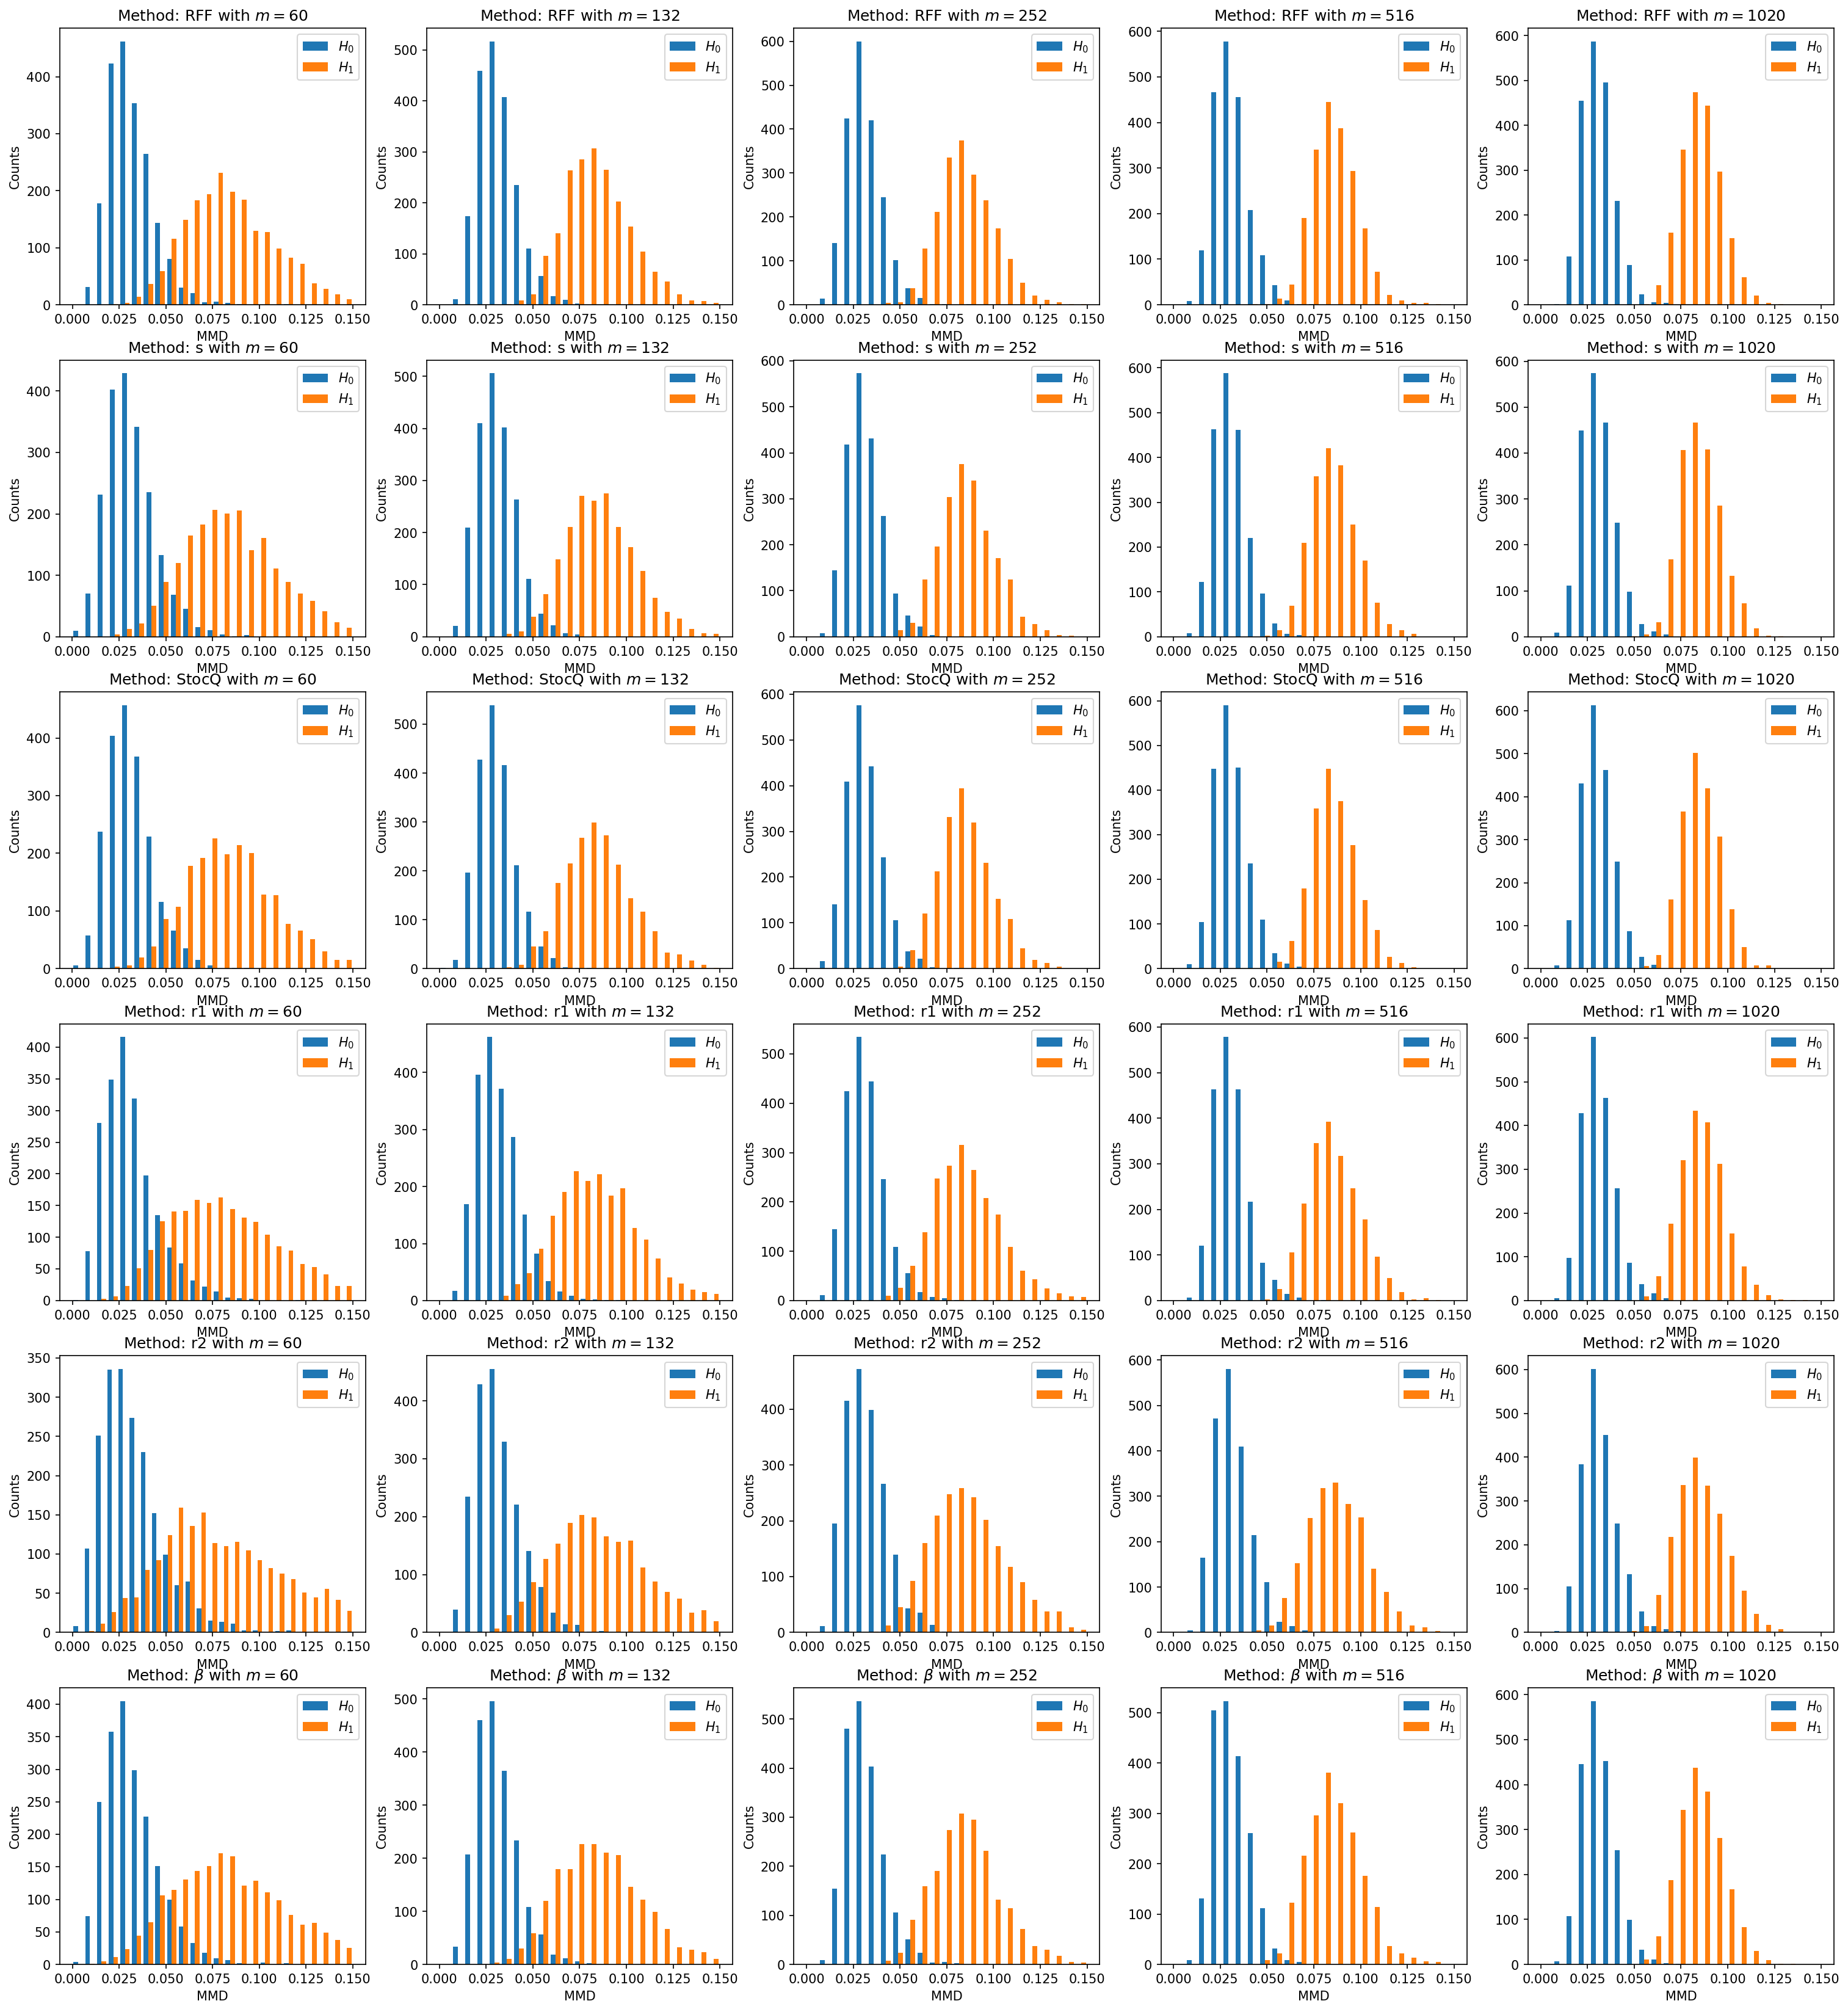

In [28]:
mmd_values_null = np.load('n60_gamma500_K4_null.npy')
mmd_values_alter = np.load('n60_gamma500_K4_alter.npy')
m_list = np.array([15, 33, 63, 129, 255]) * 4  
lambda_list = [4, 5, 4]  
q_type_list = ['RFF', 'semi-universal', 'StocQ', 'r1', 'r2', 'beta']
q_list = ['RFF', 's', 'StocQ', 'r1', 'r2', '$\\beta$']
fig = plt.figure(figsize=(25,28), dpi=150) 
for j, m in enumerate(m_list):
    for i, q_type in enumerate(q_type_list):
        ax = fig.add_subplot(len(q_type_list),len(m_list),i*len(m_list)+j+1)
        ax.hist([mmd_values_null[i,j,:], mmd_values_alter[i,j,:]], bins='auto', range=[0, 1.5e-1], density=False, label=['$H_0$', '$H_1$']) 
        if q_type == 'rbf':
            ax.set_title(f'Method: {q_list[i]}')
        else:
            ax.set_title(f'Method: {q_list[i]} with $m={m}$' )
        ax.set_xlabel('MMD')
        ax.set_ylabel('Counts')
        ax.legend() 
#plt.savefig('MMD_histograms.png') 

### (b) The power of our hypothesis test

Type II error: false negative rate $\beta$.
$$\mathrm{power}=1-\beta = \mathrm{P}(\mathrm{reject}\, \mathcal{H}_0|\,\mathcal{H}_1\mathrm{ is\,true})$$

Assume that the null hypothesis $\mathcal{H}_0$ will be rejected at the significance level of $\alpha=0.05$. Then the power of our test equals to the portion of MMD values under $\mathcal{H}_1$ that are greater than the $1-\alpha$ quantile of MMD distribution under $\mathcal{H}_0$.

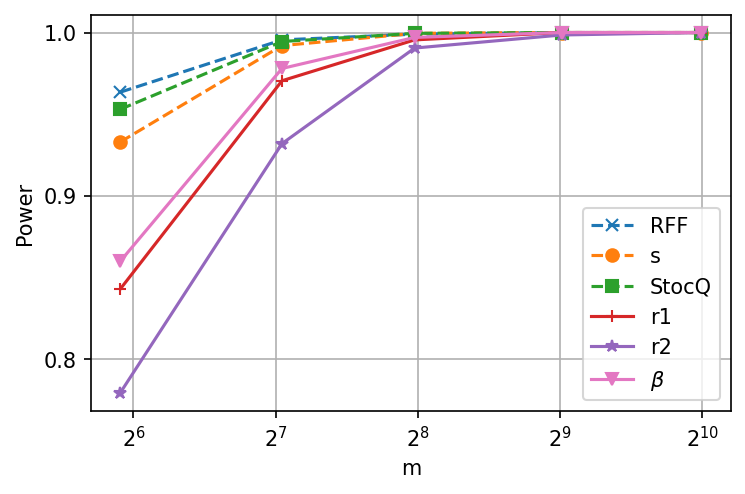

In [31]:
alpha = 0.1  # significance level
power = np.zeros((len(q_type_list), len(m_list)))
for j, m in enumerate(m_list):
    for i, q_type in enumerate(q_type_list):
        power[i, j] = np.mean(np.percentile(mmd_values_null[i, j, :], 100*(1-alpha)) <= mmd_values_alter[i, j, :])
        
fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=150)  # plot dataset 
markers = ['x', 'o', 's', '+', '*', 'v']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2"]
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        ax.plot(m_list, power[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type == 'r2':
        ax.plot(m_list, power[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type == 'beta':
        ax.plot(m_list, power[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    else:
        ax.plot(m_list, power[i], linestyle='--', marker=markers[i], color=colors[i], label=q_list[i])
ax.legend()
# ax.axis([m_list[0]-1, m_list[-1], 9.8e-1, 1.01]) 
#ax.ticklabel_format(style='sci',scilimits=(-3,-3), axis='y')
yloc = plt.MaxNLocator(3)
ax.yaxis.set_major_locator(yloc)
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_xlabel('m')
ax.set_ylabel('Power')
#ax.set_title('power') 
plt.savefig('MMD_power_b3_m.png')

In [33]:
K = 4

[int(np.log2(lambda_list[0]*(2*K-1))*m/lambda_list[0]) for m in np.array([15, 33, 63, 129, 255, 510]) * 4 ] 

[72, 158, 302, 620, 1225, 2451]

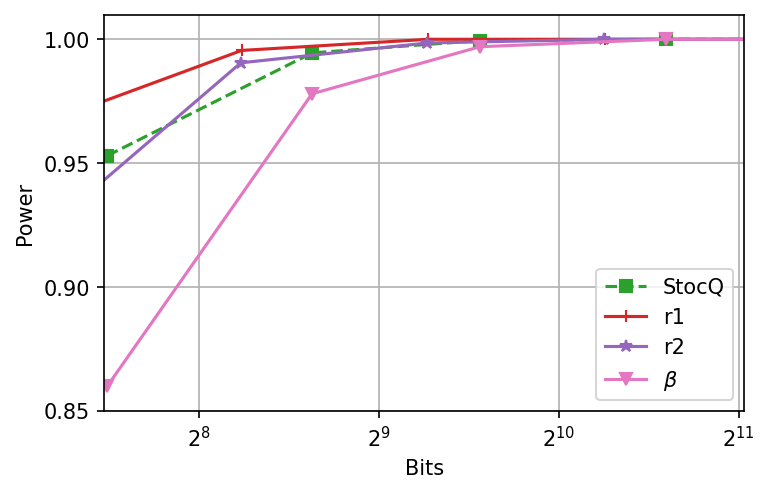

In [39]:
alpha = 0.1  # significance level
power = np.zeros((len(q_type_list), len(m_list)))
for j, m in enumerate(m_list):
    for i, q_type in enumerate(q_type_list):
        power[i, j] = np.mean(np.percentile(mmd_values_null[i, j, :], 100*(1-alpha)) <= mmd_values_alter[i, j, :])
        
fig, ax = plt.subplots(figsize=(5.5,3.5), dpi=150)  # plot dataset 
markers = ['x', 'o', 's', '+', '*', 'v']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2"]
K = 4
for i, q_type in enumerate(q_type_list):
    if q_type == 'r1':
        bit_list = [int(np.log2(lambda_list[0]*(2*K-1))*m/lambda_list[0]) for m in m_list]
        ax.plot(bit_list+[2451], np.concatenate((power[i], [1])), linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type == 'r2':
        bit_list = [int((2*np.log2(lambda_list[1]+1)+np.log2(2*K-1)-2)*m/lambda_list[1]) for m in m_list]    
        ax.plot(bit_list+[2438], np.concatenate((power[i], [1])), linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type == 'beta':
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, power[i], linestyle='-', marker=markers[i], color=colors[i], 
                label=q_list[i])
    elif q_type in ['rbf', 'RFF', 'semi-universal']:
        continue
    else:       
        bit_list = [int(m*np.log2(2*K)) for m in m_list]
        ax.plot(bit_list, power[i], linestyle='--', marker=markers[i], color=colors[i], label=q_list[i])
          
ax.legend(loc='lower right')
yloc = plt.MaxNLocator(4)
ax.yaxis.set_major_locator(yloc)
ax.axis([bit_list[0]-2, 2**11 + 40, 0.85, 1.01]) 
ax.grid(True)
ax.set_xscale('log', base=2)
ax.set_xlabel('Bits')
ax.set_ylabel('Power') 
plt.savefig('MMD_power_b3_bit.png')

In [ ]:
# from sklearn.kernel_ridge import KernelRidge
# m_list = [30, 60, 120, 240, 360, 480, 960, 1920]
# lambda_dict = dict(r1=2, r2=3, beta=5)
# beta = 1.5
# SDQ_level_list = [3, 3, 3, 3]
# M = 5 # the number of repeated experiments 
# q_type_list = ['rbf', 'RFF', 'universal-1', 'universal-2', 'StocQ', 'r1', 'r2', 'beta']
# tolerance = 1e-10
# test_mse = np.zeros((M, len(q_type_list), len(m_list)))
# bit_array = np.zeros((M, 3, len(m_list)))
# alpha = 1

# for t in range(M):
#     for j, m in enumerate(m_list):
#         xi = np.random.uniform(0, 2*np.pi, size=(m,1))
#         omega = np.random.randn(n_features, m) * np.sqrt(2*gamma) 
#         for i, q_type in enumerate(q_type_list):
#             if q_type == 'rbf':
#                 clf = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
#                 clf.fit(X_train, y_train)
#                 test_mse[t, i, j] = np.mean(((clf.predict(X_test) - y_test)/y_test) ** 2)   #np.mean((clf.predict(X_test) - y_test) ** 2)
#                 if t == 0 and j == 0:
#                     print(f'Lower bound of MSE is around {test_mse[t, i, j]}.')
                
#             elif q_type == 'RFF':
#                 X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
#                 clf = KernelRidge(alpha=alpha, kernel='linear')
#                 clf.fit(X_train_RFF, y_train)
#                 X_test_RFF = np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T * np.sqrt(2/m)
#                 test_mse[t, i, j] = np.mean(((clf.predict(X_test_RFF) - y_test)/y_test) ** 2)   #np.mean((clf.predict(X_test_RFF) - y_test) ** 2)
                
#             elif q_type == 'universal-1':
#                 X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
#                 clf = KernelRidge(alpha=alpha, kernel='linear')
#                 clf.fit(X_train_RFF, y_train)
#                 X_test_q = np.sign(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0])))).T * np.pi/np.sqrt(8*m)
#                 test_mse[t, i, j] = np.mean(((clf.predict(X_test_q) - y_test)/y_test) ** 2)   #np.mean((clf.predict(X_test_q) - y_test) ** 2)
                
#             elif q_type == 'universal-2':
#                 X_train_RFF = np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T * np.sqrt(2/m)
#                 clf = KernelRidge(alpha=alpha, kernel='linear')
#                 clf.fit(X_train_RFF, y_train)
#                 dual_coef = clf.dual_coef_
#                 X_test_RFF = np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T * np.pi/(2*m)
#                 X_train_q = np.sign(X_train_RFF)
#                 y_predict = np.zeros(len(X_test_RFF))
#                 for ix in range(len(X_test_RFF)):
#                     y_predict[ix] = np.dot(dual_coef, (X_train_q @ X_test_RFF[ix].reshape((m, 1))).flatten())
#                 test_mse[t, i, j] = np.mean(((y_predict - y_test)/y_test) ** 2)   #np.mean((y_predict - y_test) ** 2)
                
#             elif q_type == 'StocQ':
#                 X_train_q = StocQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))), SDQ_level_list[0]).T * np.sqrt(2/m)
#                 clf = KernelRidge(alpha=alpha, kernel='linear')
#                 clf.fit(X_train_q, y_train)
#                 X_test_q = StocQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))), SDQ_level_list[0]).T * np.sqrt(2/m)
#                 test_mse[t, i, j] = np.mean(((clf.predict(X_test_q) - y_test)/y_test) ** 2)   # np.mean((clf.predict(X_test_q) - y_test) ** 2)
                
#             elif q_type in ['r1', 'r2', 'beta']:
#                 lambda_ = lambda_dict[q_type]
#                 p = int(m/lambda_)
#                 if q_type == 'r1':
#                     v = np.ones(lambda_)  # row vector v
#                     V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)  # normalized sparse V
#                     X_train_q = (V @ SDQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, 1, SDQ_level_list[1]).T).T
#                     bit_array[t,0,j] = p * avg_bit(X_train_q)
#                 elif q_type == 'r2':
#                     v = np.concatenate([np.arange(1,(lambda_+1)/2+1), np.arange((lambda_-1)/2, 0, -1)])
#                     V = np.sqrt(2/p) * np.kron(np.eye(p), v) /np.linalg.norm(v)
#                     X_train_q = (V @ SDQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, 2, SDQ_level_list[2]).T).T
#                     bit_array[t,1,j] = p * avg_bit(X_train_q) 
#                 elif q_type == 'beta':
#                     v = beta ** np.arange(-1, -lambda_-1, -1)
#                     V = np.sqrt(2/p) * np.kron(np.eye(p), v) / (np.linalg.norm(v) * (2-beta))
#                     X_train_q = (V @ BetaQ(np.cos(omega.T @ X_train.T + xi @ np.ones((1, X_train.shape[0]))).T, beta, lambda_, SDQ_level_list[3]).T).T
#                     bit_array[t,2,j] = p * avg_bit(X_train_q) 
#                 clf = KernelRidge(alpha=alpha, kernel='linear')
#                 clf.fit(X_train_q, y_train) 
#                 if q_type == 'r1':
#                     X_test_q = (V @ SDQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T, 1, SDQ_level_list[1]).T).T
#                 elif q_type == 'r2':
#                     X_test_q = (V @ SDQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T, 2, SDQ_level_list[2]).T).T
#                 elif q_type == 'beta':
#                     X_test_q = (V @ BetaQ(np.cos(omega.T @ X_test.T + xi @ np.ones((1, X_test.shape[0]))).T, beta, lambda_, SDQ_level_list[3]).T).T
#                 test_mse[t, i, j] = np.mean(((clf.predict(X_test_q) - y_test)/y_test) ** 2)   #np.mean((clf.predict(X_test_q) - y_test) ** 2)             
# test_mse = test_mse.mean(axis=0)
# bit_array = bit_array.mean(axis=0)
# np.save('test_mse_regression', test_mse)
# np.save('bit_array_regression', bit_array)

In [ ]:
# # Use the ground truth number of bits
# # test_accuracy = np.load('test_accuracy_svm.npy')
# # bit_array = np.load('bit_array_svm.npy')
# fig, ax = plt.subplots(figsize=(10,8))  # plot the curve of accuracy

# markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
# K = SDQ_level_list[0]
# for i, q_type in enumerate(q_type_list):
#     if q_type == 'r1':
#         ax.plot(bit_array[0], test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
#                 label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
#     elif q_type == 'r2':
#         ax.plot(bit_array[1], test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
#                 label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
#     elif q_type == 'beta': 
#         ax.plot(bit_array[2], test_accuracy[i], linestyle='-', marker=markers[i], color=colors[i], 
#                 label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
#     elif q_type in ['rbf', 'RFF']:
#         continue
#     else:       
#         bit_list = [int(m*np.log2(2*K)) for m in m_list]
#         ax.plot(bit_list , test_accuracy[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
# ax.legend()
# ax.axis([bit_list[0]-30, bit_list[-2]+100, 9.65e-1, 9.95e-1]) 
# ax.grid(True)
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=10)
# ax.set_xlabel('Bits')
# ax.set_title('Prediction Accuracy on testing dataset') 
# #plt.savefig('test_accuracy_scale.png')

In [ ]:
# Use the ground truth number of bits
# test_mse = np.load('test_mse_regression.npy')
# bit_array = np.load('bit_array_regression.npy')

# fig, ax = plt.subplots(figsize=(12,7))  # plot the curve of accuracy

# markers = ['x', 'o', 's', '+', '*', 'v', 'p', 'D']
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#e377c2", "#bcbd22", '#17becf']
# K = SDQ_level_list[0]
# for i, q_type in enumerate(q_type_list):
#     if q_type == 'r1':
#         ax.plot(bit_array[0], test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
#                 label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
#     elif q_type == 'r2':
#         ax.plot(bit_array[1], test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
#                 label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
#     elif q_type == 'beta':
#         ax.plot(bit_array[2], test_mse[i], linestyle='-', marker=markers[i], color=colors[i], 
#                 label=q_type_list[i]+f' with $\lambda={lambda_dict[q_type]}$')
#     elif q_type in ['rbf', 'RFF']:
#         continue
#     else:       
#         bit_list = [int(m*np.log2(2*K)) for m in m_list]
#         ax.plot(bit_list , test_mse[i], linestyle='--', marker=markers[i], color=colors[i], label=q_type_list[i])
# ax.legend()
# ax.axis([bit_list[0]-1, bit_array[1][-1], 7.15e-3, 8e-3]) 
# ax.grid(True)
# ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=10)
# ax.set_xlabel('Bits')
# ax.set_title(f'MSE on testing dataset with $\gamma={np.round(gamma,2)}$ and $\sigma={sigma}$') 
# #plt.savefig('test_accuracy_scale.png')